<a href="https://colab.research.google.com/github/aswin-ar3669/MLA-Python-Learning/blob/main/RA2512049015006_MLA_Hackatons_SEM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# default-prediction.ipynb

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, QuantileTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn import set_config

import matplotlib.pyplot as plt
import seaborn as sns6

from lightgbm import LGBMClassifier

# File paths (edit if needed)
TRAIN_PATH = "Train_set.csv"      # must contain 'ID' and 'default'
TEST_PATH  = "Test_set.csv"       # must contain 'ID'
SUBMIT_PATH = "submission_lgbm.csv"

# Reproducibility
SEED = 42
N_ITER_COUNT = 5
K_FOLD_COUNT = 3
np.random.seed(SEED)


In [44]:
# Load train and test
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# Basic checks
assert "ID" in train.columns and "default" in train.columns, "Train must have ID and default"
assert "ID" in test.columns, "Test must have ID"
print(train.shape, test.shape)
train.head(3), test.head(3)


(93174, 23) (39933, 22)


(         ID  loan_amnt loan_term  interest_rate loan_grade loan_subgrade  \
 0  72199369       9000   3 years           9.17          B            B2   
 1  14257956      18000   3 years          13.65          C            C1   
 2  66216451      16000   3 years           7.26          A            A4   
 
   job_experience home_ownership  annual_income income_verification_status  \
 0       <5 Years            OWN        85000.0               Not Verified   
 1       <5 Years            OWN        64000.0                   Verified   
 2       <5 Years       MORTGAGE       150000.0            Source Verified   
 
    ... delinq_2yrs public_records  revolving_balance  total_acc  \
 0  ...         0.0            0.0              39519       20.0   
 1  ...         0.0            1.0               9783       24.0   
 2  ...         2.0            0.0              13641       27.0   
 
    interest_receive  application_type  last_week_pay  total_current_balance  \
 0             59.60  

In [45]:
# According to Data_Dictionary_-1.csv:
# Numeric-like
num_cols = [
    "loan_amnt","interest_rate","job_experience","annual_income",
    "debt_to_income","delinq_2yrs","public_records","revolving_balance",
    "total_acc","interest_receive","last_week_pay","total_current_balance","total_revolving_limit"
]

# Categorical-like
cat_cols = [
    "loan_term","loan_grade","loan_subgrade","home_ownership","income_verification_status",
    "loan_purpose","state_code","application_type"
]

# Ensure we only keep columns that exist
num_cols = [c for c in num_cols if c in train.columns]
cat_cols = [c for c in cat_cols if c in train.columns]

used_features = num_cols + cat_cols
print("Using features:", used_features)

Using features: ['loan_amnt', 'interest_rate', 'job_experience', 'annual_income', 'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay', 'total_current_balance', 'total_revolving_limit', 'loan_term', 'loan_grade', 'loan_subgrade', 'home_ownership', 'income_verification_status', 'loan_purpose', 'state_code', 'application_type']


In [46]:
set_config(transform_output="pandas")

def clean_columns(df):
    df = df.copy()
    # only mutate existing columns (parse_job_experience, parse_last_week_pay, parse_loan_term)
    return df[used_features]

# 1) Cleaner should NOT claim one-to-one if it could reorder or filter
cleaner = FunctionTransformer(
    clean_columns,
    validate=False,
    feature_names_out=None
)


# Custom transformers
def build_credit_ratios(df):
    df = df.copy()
    eps = 1.0
    if "revolving_balance" in df and "total_revolving_limit" in df:
        df["revolving_util"] = np.clip(
            df["revolving_balance"] / (df["total_revolving_limit"].replace(0, eps)),
            0, 1.5
        )
    if "annual_income" in df and "loan_amnt" in df:
        df["income_to_loan"] = df["annual_income"] / (df["loan_amnt"].replace(0, eps))
    if "interest_receive" in df and "annual_income" in df:
        df["payment_burden"] = df["interest_receive"] / (df["annual_income"].replace(0, eps))
    if "delinq_2yrs" in df:
        df["delinquency_flag"] = (df["delinq_2yrs"] > 0).astype(int)
    if "public_records" in df:
        df["public_records_flag"] = (df["public_records"] > 0).astype(int)
    if "total_acc" in df and "total_current_balance" in df:
        df["balance_per_line"] = df["total_current_balance"] / (df["total_acc"].replace(0, eps))
    # Missingness flags
    for col in ["job_experience","last_week_pay","loan_term"]:
        if col in df:
            df[f"{col}_is_null"] = df[col].isna().astype(int)
    return df

def add_features(df):
    return build_credit_ratios(df)     # adds new columns


# 2) Feature builder already returns a DataFrame with appended columns
feature_builder = FunctionTransformer(
    add_features,
    validate=False,
    feature_names_out=None
)

cleaner = FunctionTransformer(clean_columns, validate=False, feature_names_out=None)
feature_builder = FunctionTransformer(add_features, validate=False, feature_names_out=None)

engineered_cols = [
    "revolving_util","income_to_loan","payment_burden",
    "delinquency_flag","public_records_flag","balance_per_line",
    "job_experience_is_null","last_week_pay_is_null","loan_term_is_null"
]

numeric_transform_cols = sorted(set([c for c in num_cols if c != "job_experience"] + engineered_cols))
categorical_transform_cols = sorted(set(cat_cols + ["job_experience"]))

numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("quantiles", QuantileTransformer(output_distribution="normal", n_quantiles=200)),
    ("scale", StandardScaler(with_mean=False))
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = Pipeline([
    ("cleaner", cleaner),
    ("feature_builder", feature_builder),
    ("columnwise", ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_transform_cols),
            ("cat", categorical_pipeline, categorical_transform_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    ))
])


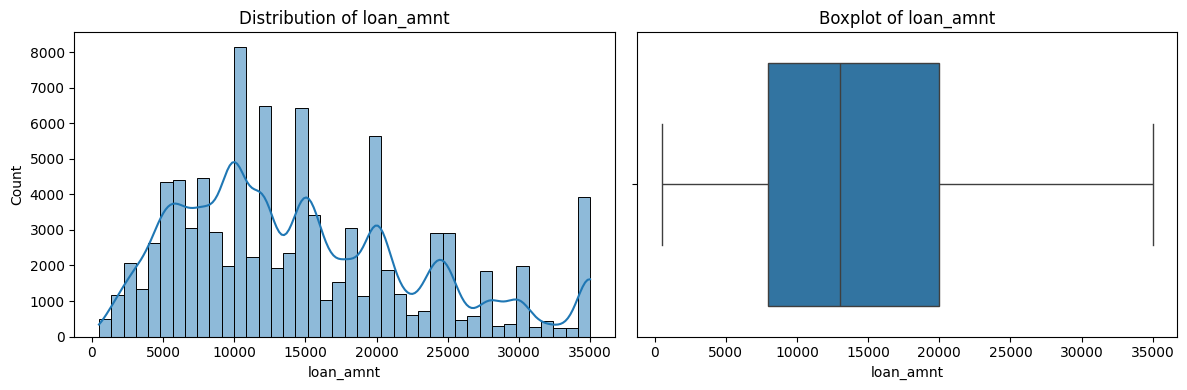

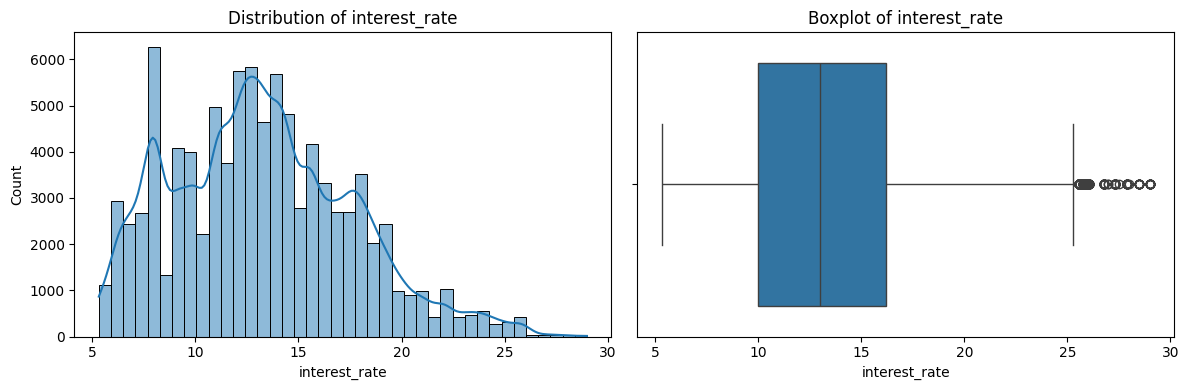

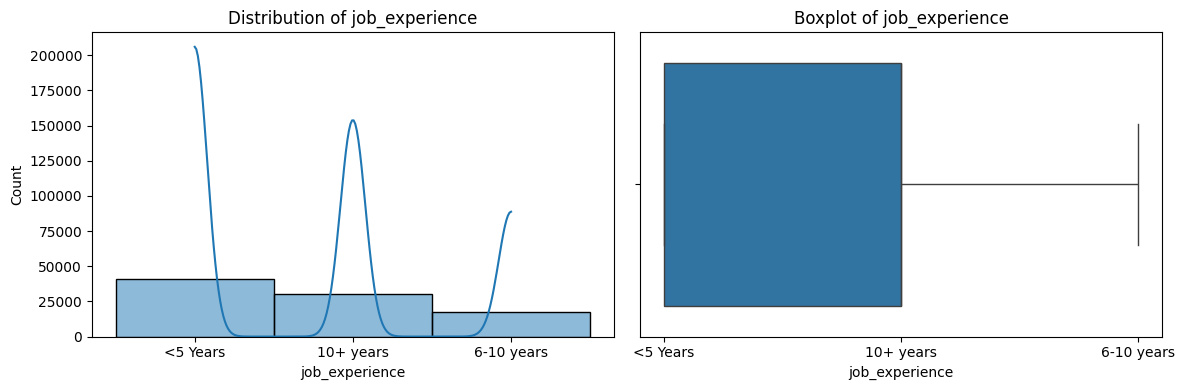

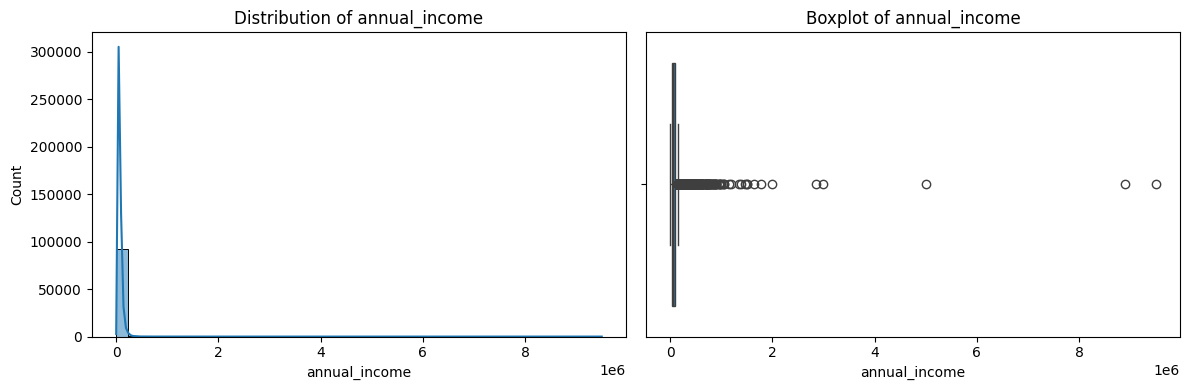

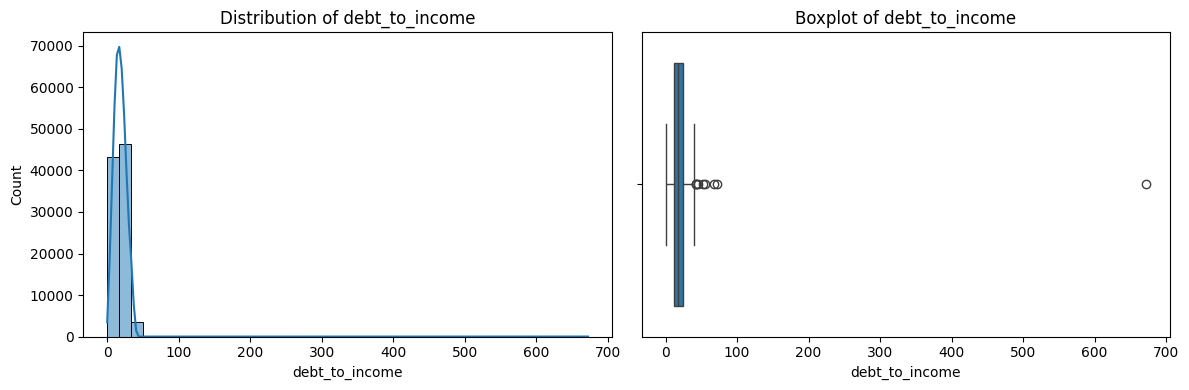

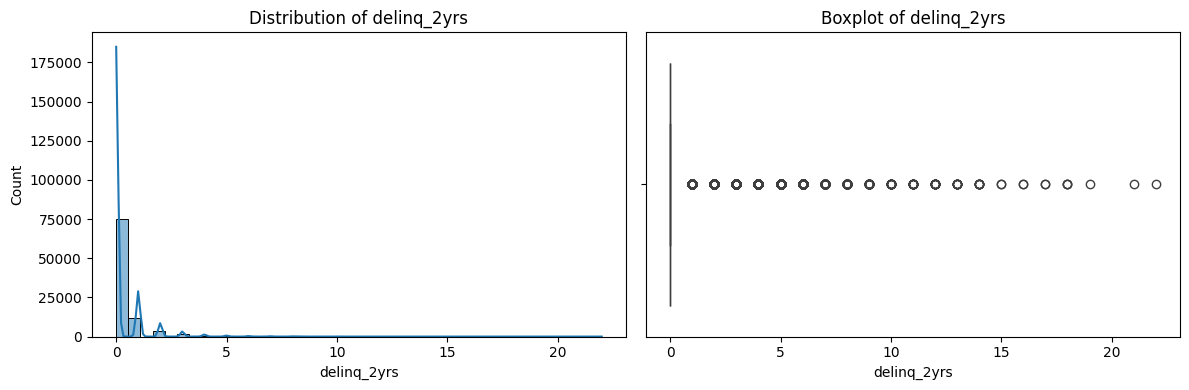

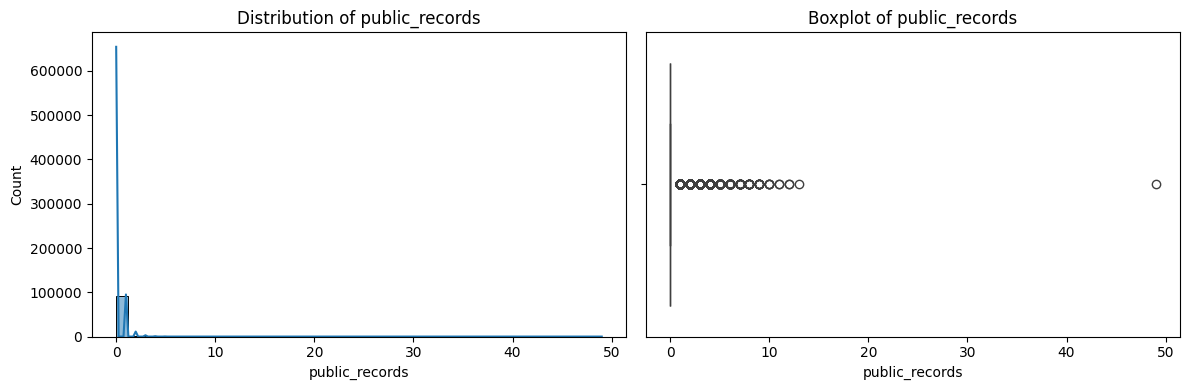

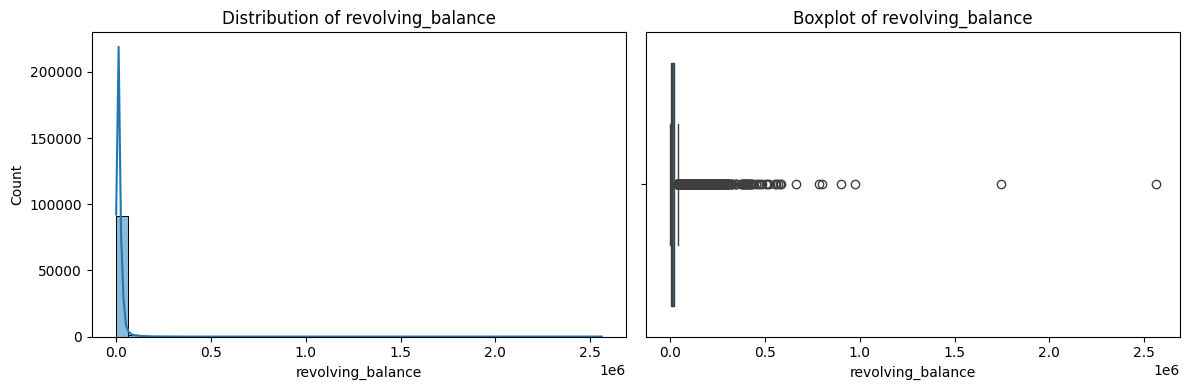

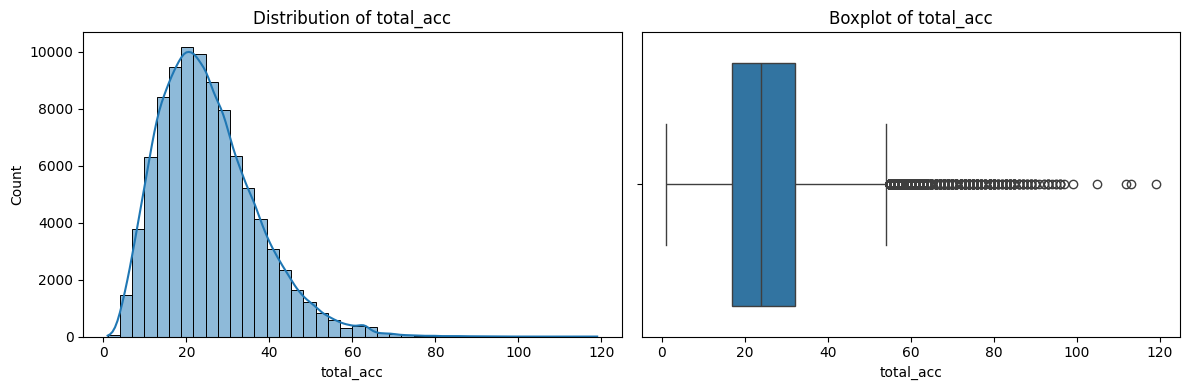

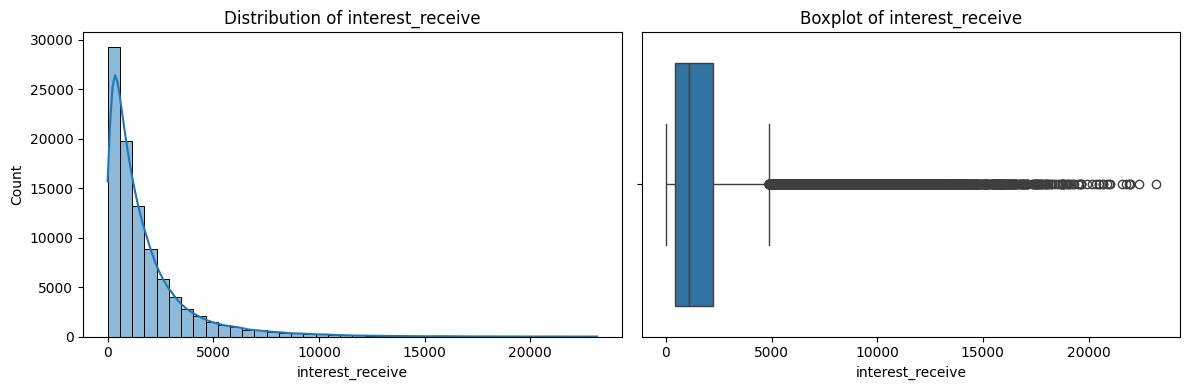

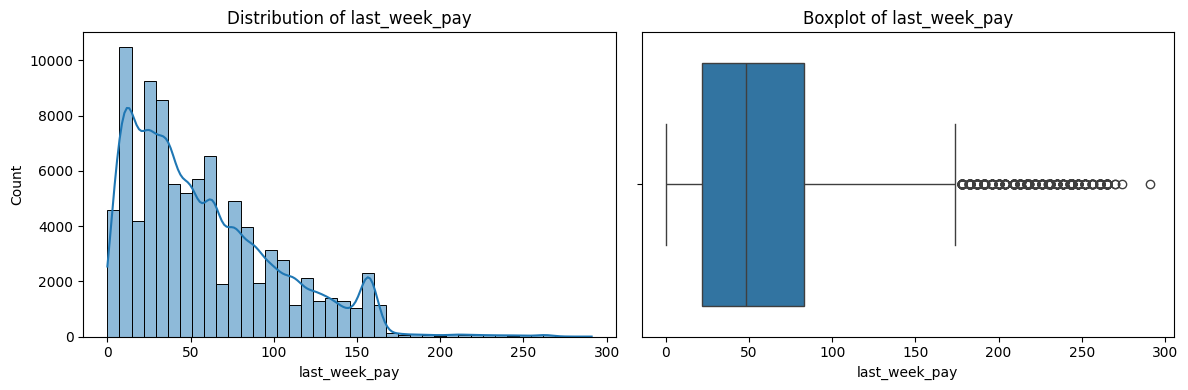

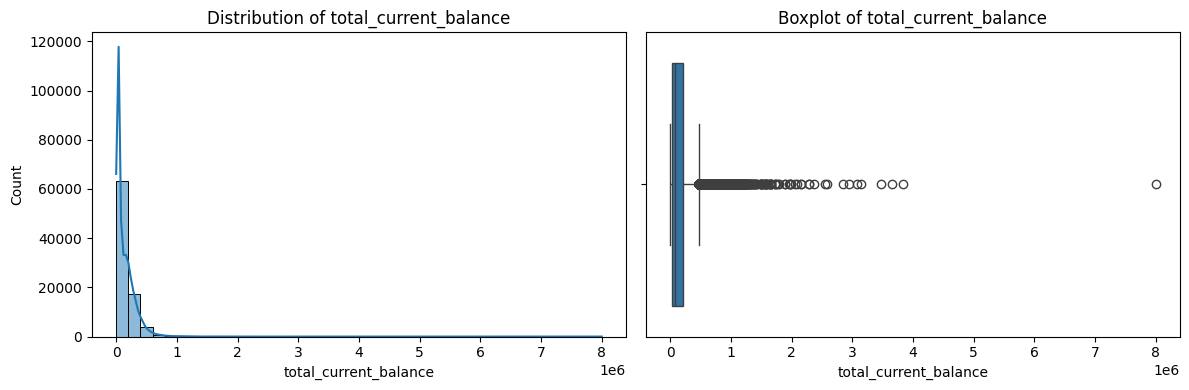

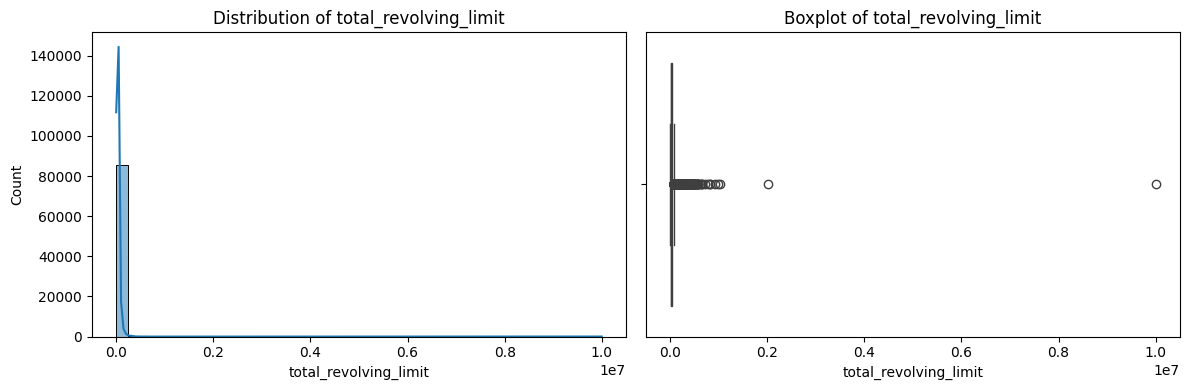

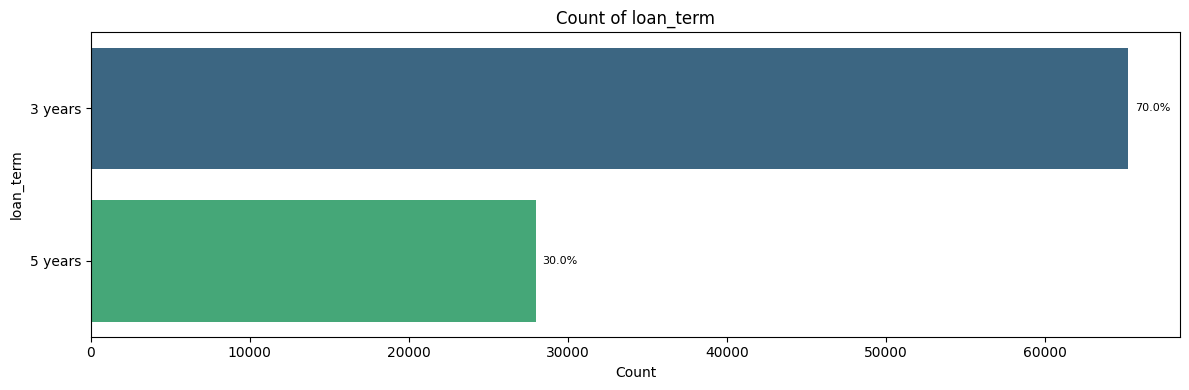

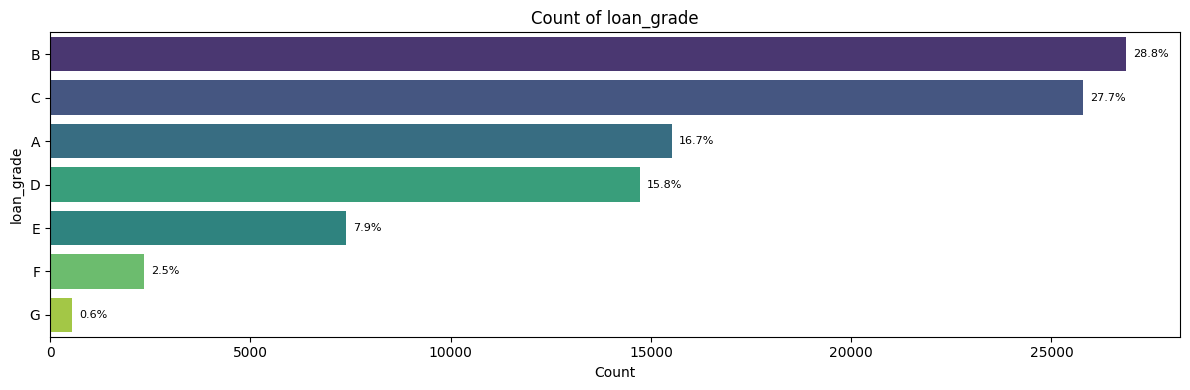

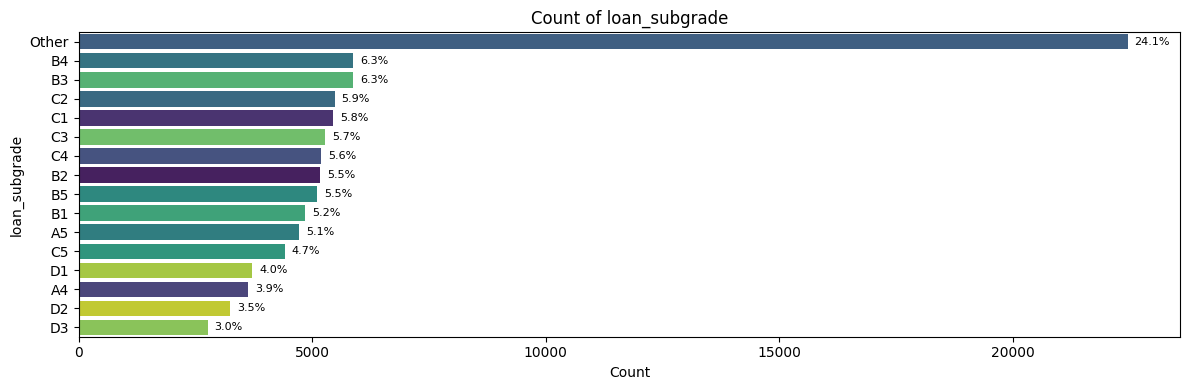

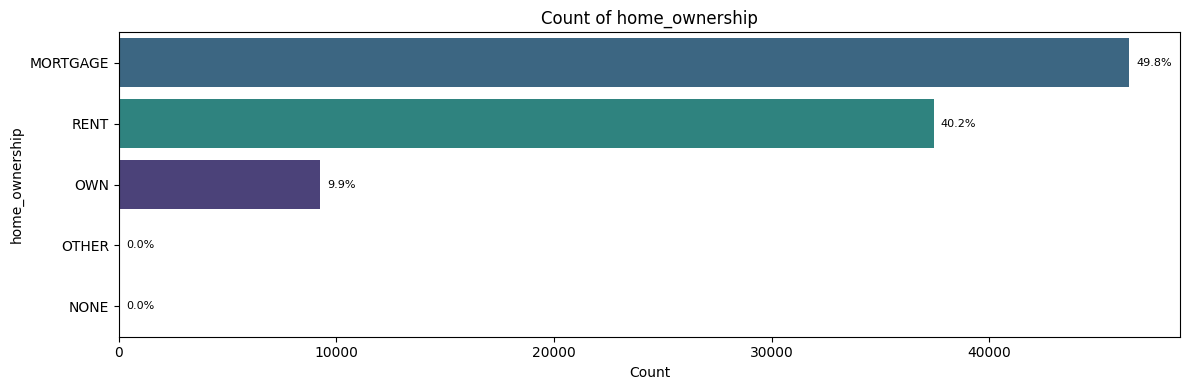

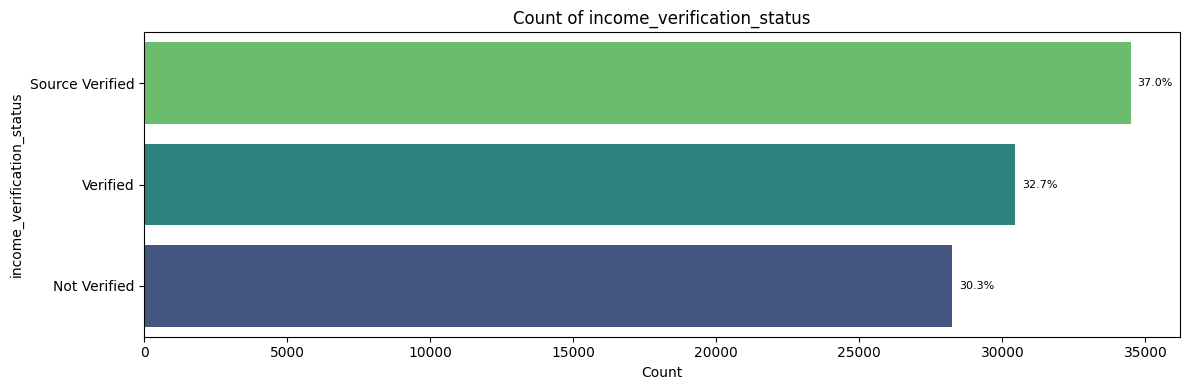

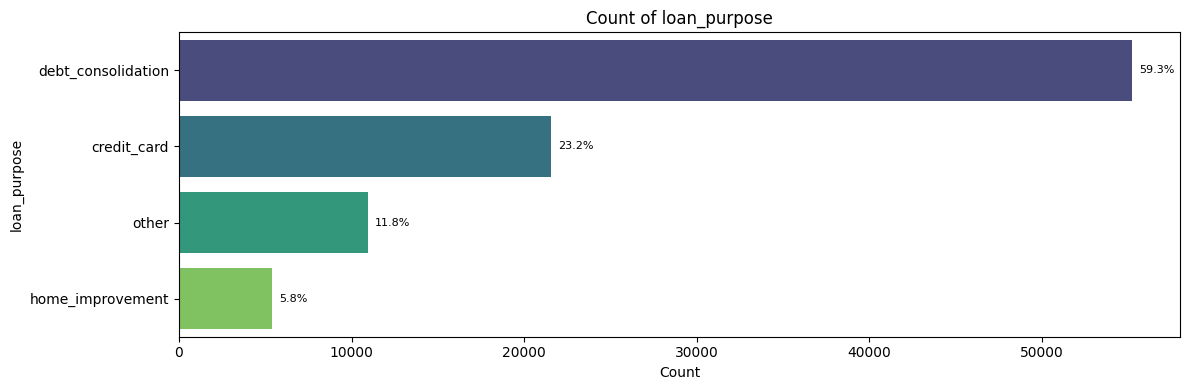

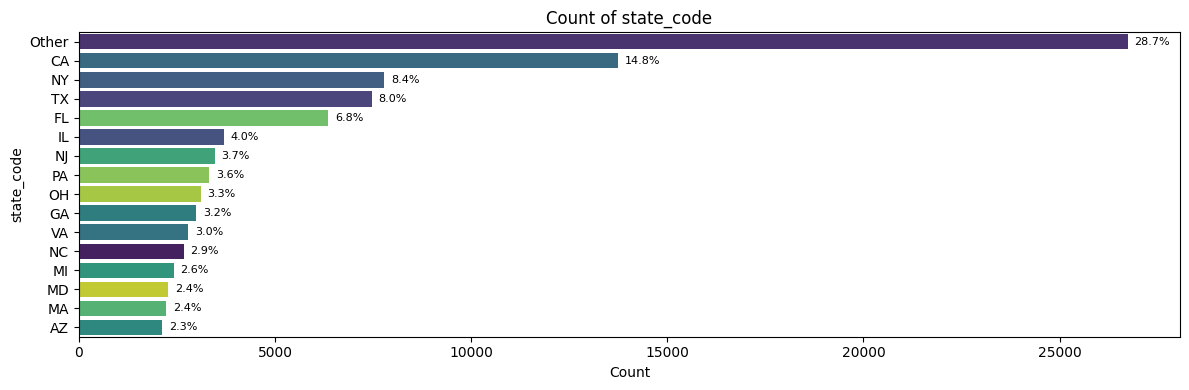

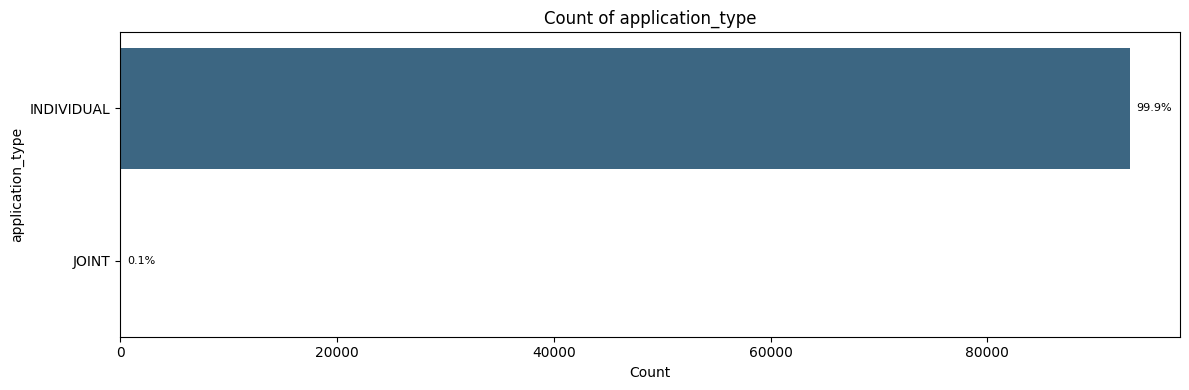

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TARGET = "default"  # change if your target column has a different name

# Filter to existing columns (already done in your snippet)
used_features = num_cols + cat_cols

# 1) Numeric: hist+KDE and boxplots
def plot_univariate_numeric(df, numeric_cols, bins=40):
    n = len(numeric_cols)
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[0])
        axes[0].set_title(f"Distribution of {col}")
        axes[0].set_xlabel(col)

        sns.boxplot(x=df[col], ax=axes[1], orient="h")
        axes[1].set_title(f"Boxplot of {col}")
        axes[1].set_xlabel(col)
        plt.tight_layout()
        plt.show()

plot_univariate_numeric(train, num_cols)

# 2) Categorical: countplots with percent labels
def plot_univariate_categorical(df, categorical_cols, top_k=None):
    for col in categorical_cols:
        vc = df[col].value_counts(dropna=False)
        if top_k is not None and len(vc) > top_k:
            # keep top_k and group the rest as "Other"
            top_vals = vc.iloc[:top_k].index
            df_plot = df.copy()
            df_plot[col] = np.where(df_plot[col].isin(top_vals), df_plot[col], "Other")
        else:
            df_plot = df

        plt.figure(figsize=(12, 4))
        ax = sns.countplot(
            data=df_plot,
            y=col,
            order=df_plot[col].value_counts().index,
            hue=col,                 # tie colors to categories
            dodge=False,             # avoid double bars since hue == y
            palette="viridis",
            legend=False             # hide redundant legend
        )
        plt.title(f"Count of {col}")
        plt.xlabel("Count")
        plt.ylabel(col)

        # Add percentages
        total = len(df_plot)
        for p in ax.patches:
            height = p.get_width() # For horizontal bar plot, width is the value
            ax.annotate(f"{100*height/total:.1f}%", (height, p.get_y()+p.get_height()/2.),
                        ha='left', va='center', fontsize=8, rotation=0, xytext=(5, 0), textcoords='offset points')
        plt.tight_layout()
        plt.show()

plot_univariate_categorical(train, cat_cols, top_k=15)

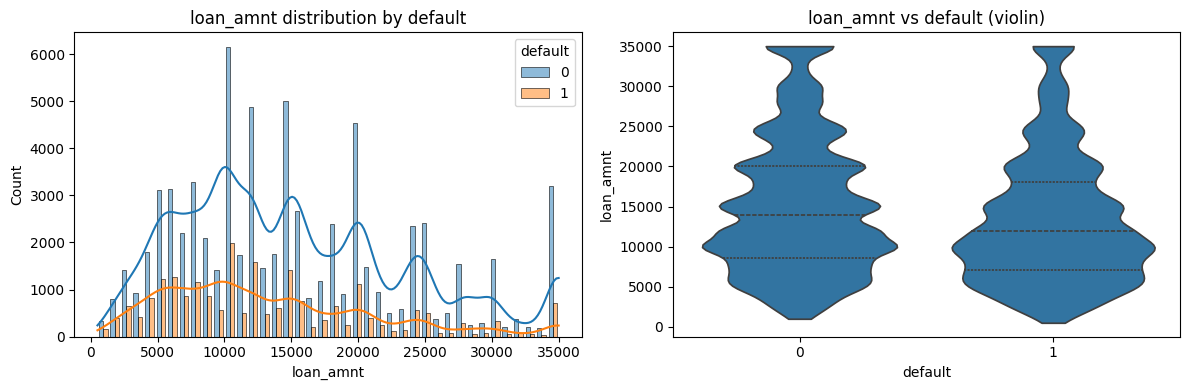

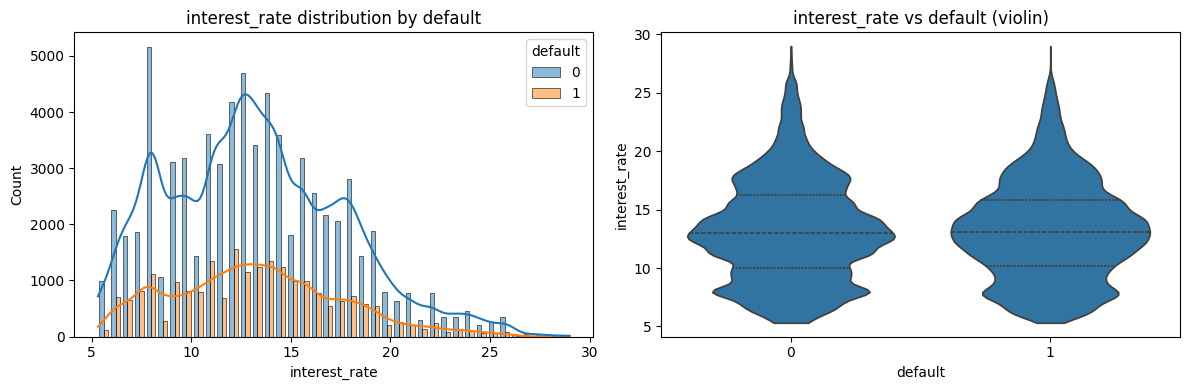

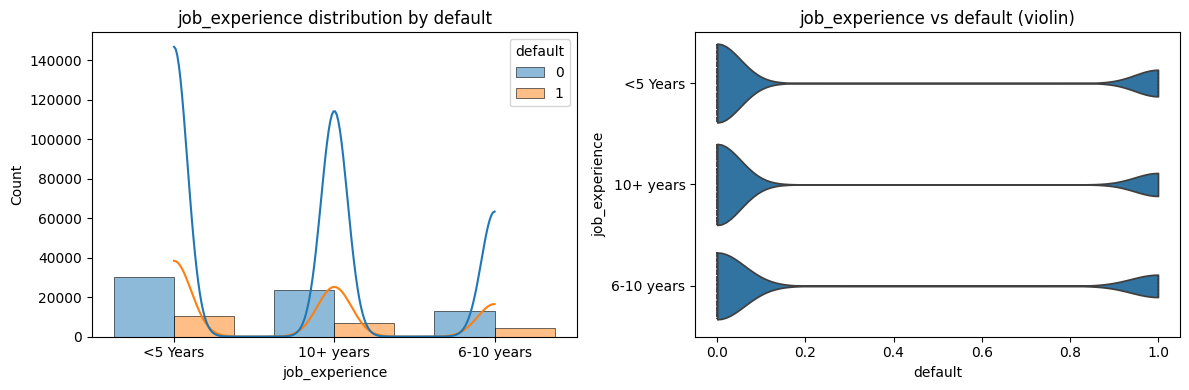

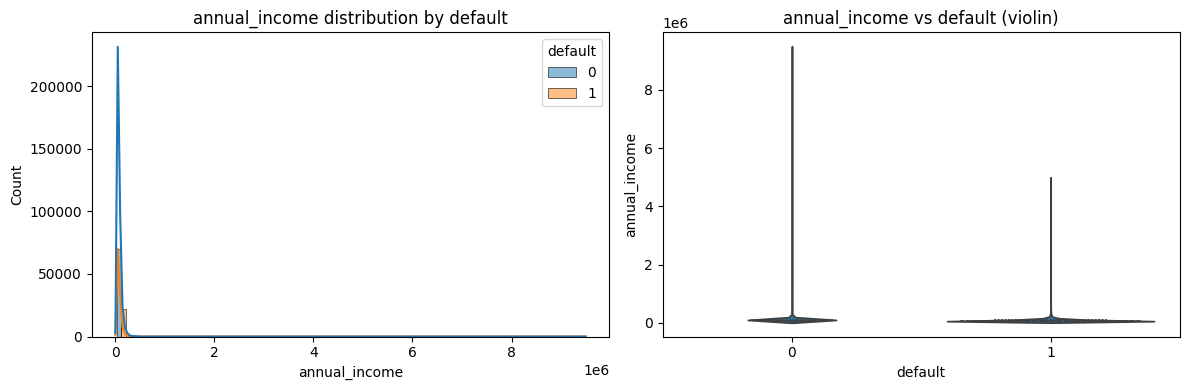

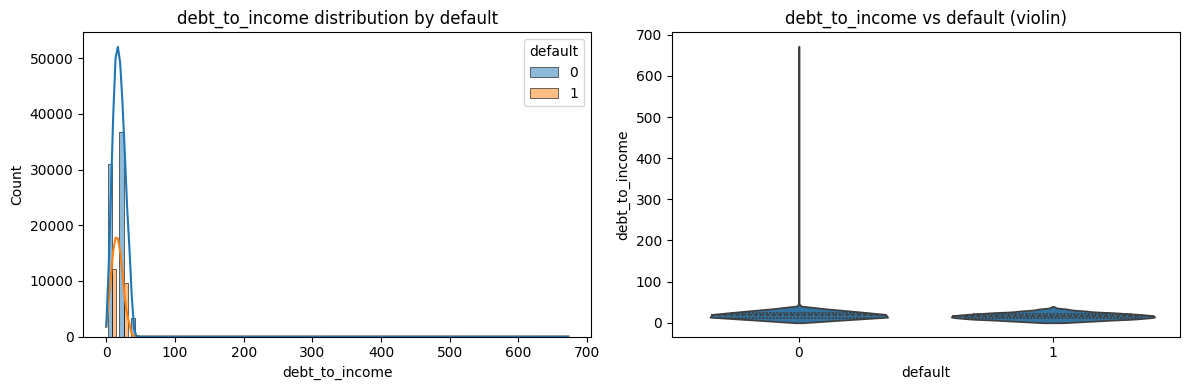

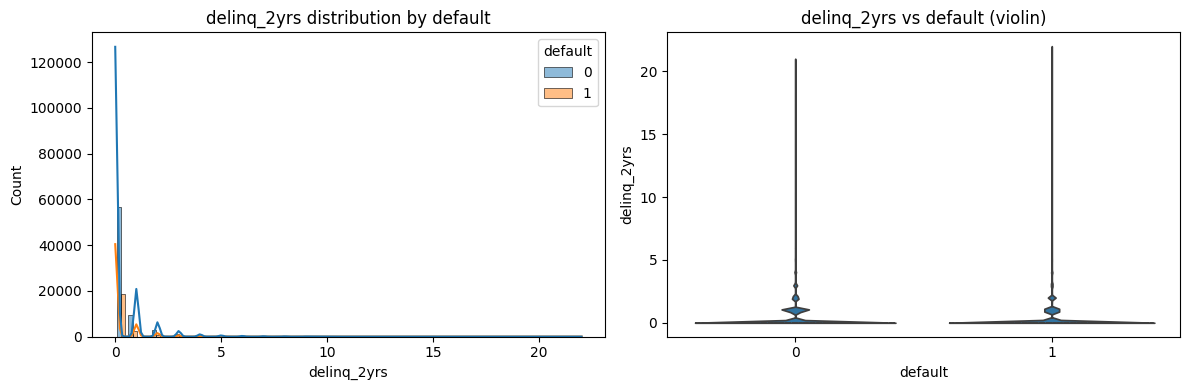

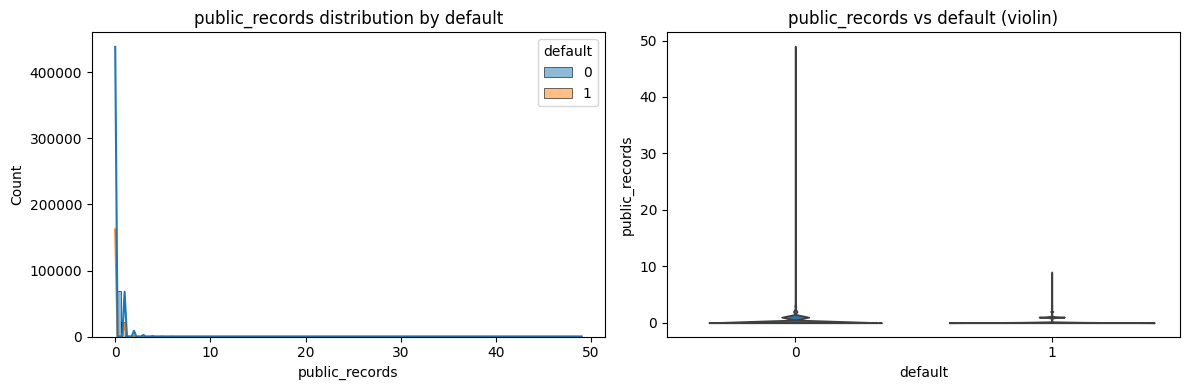

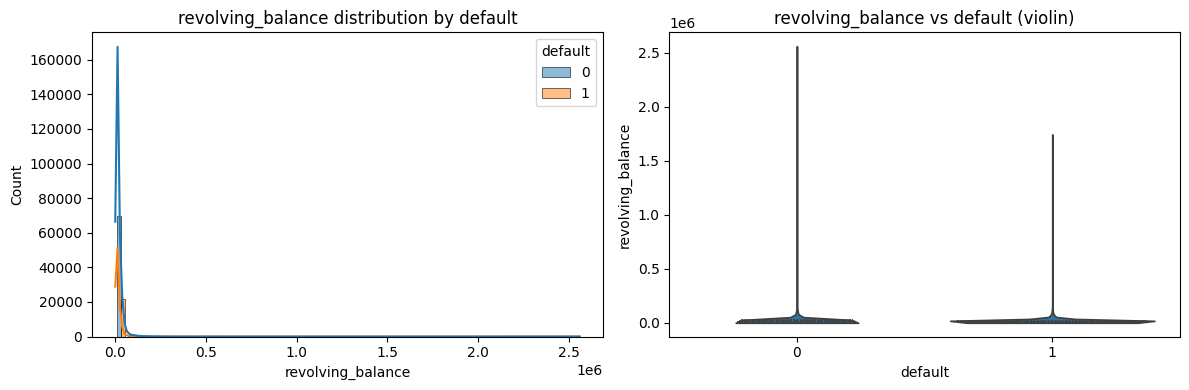

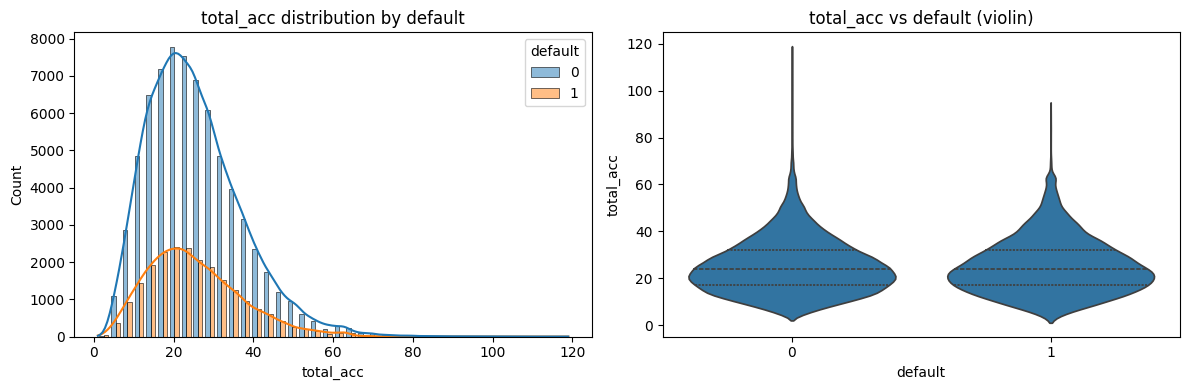

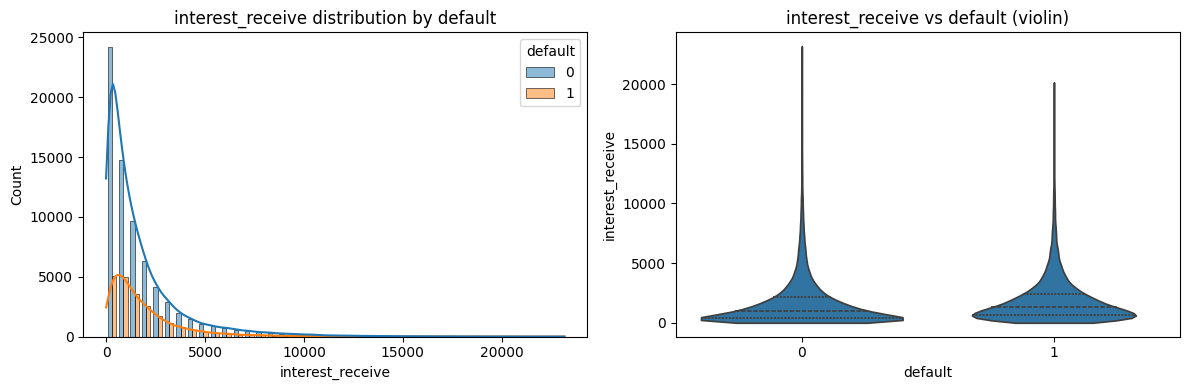

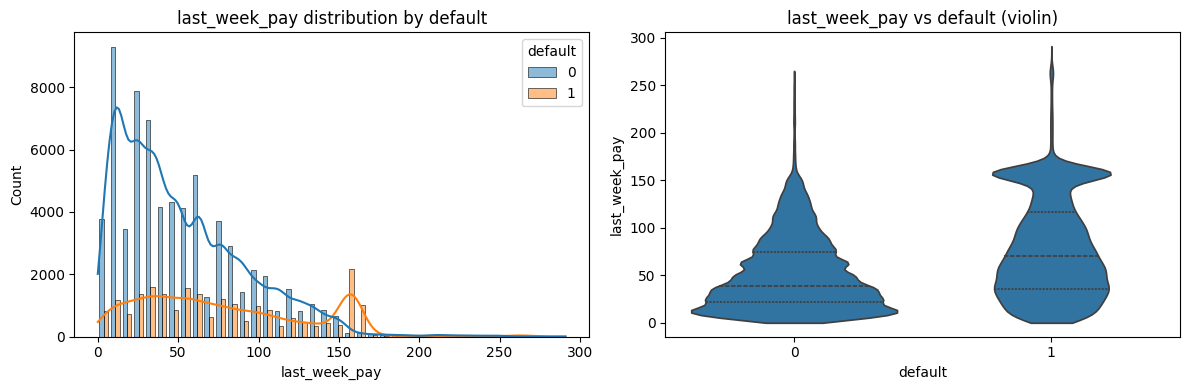

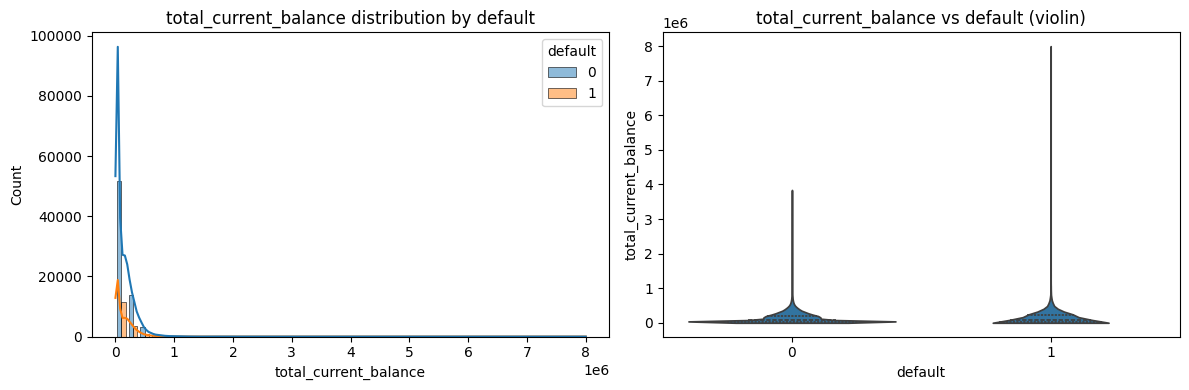

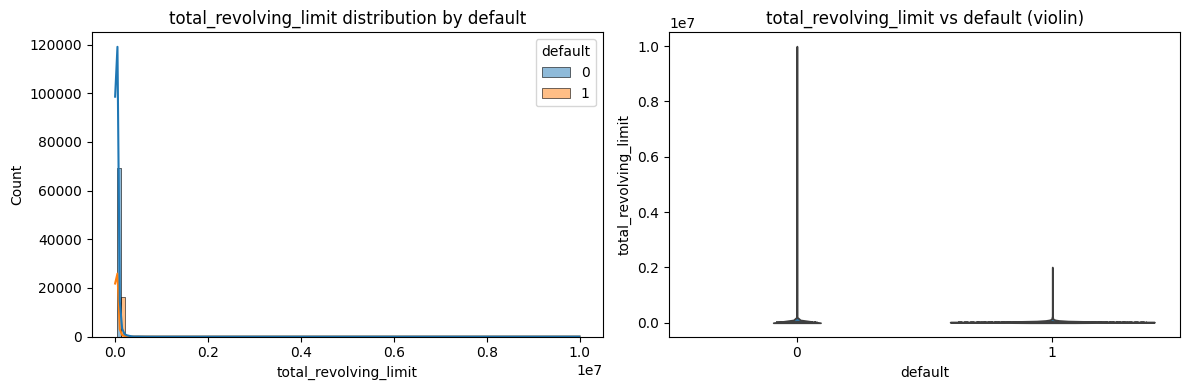

In [48]:
def plot_numeric_vs_target(df, numeric_cols, target=TARGET, bins=40):
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(
            data=df, x=col, hue=target, bins=bins, kde=True, stat="count",
            common_norm=False, multiple="dodge", shrink=0.75,
            edgecolor="black", linewidth=0.4, ax=axes[0], palette="tab10"
        )
        axes[0].set_title(f"{col} distribution by {target}")
        axes[0].set_xlabel(col)

        sns.violinplot(data=df, x=target, y=col, cut=0, inner="quartile", ax=axes[1])
        axes[1].set_title(f"{col} vs {target} (violin)")
        axes[1].set_xlabel(target)
        axes[1].set_ylabel(col)
        plt.tight_layout()
        plt.show()

plot_numeric_vs_target(train, num_cols, TARGET)

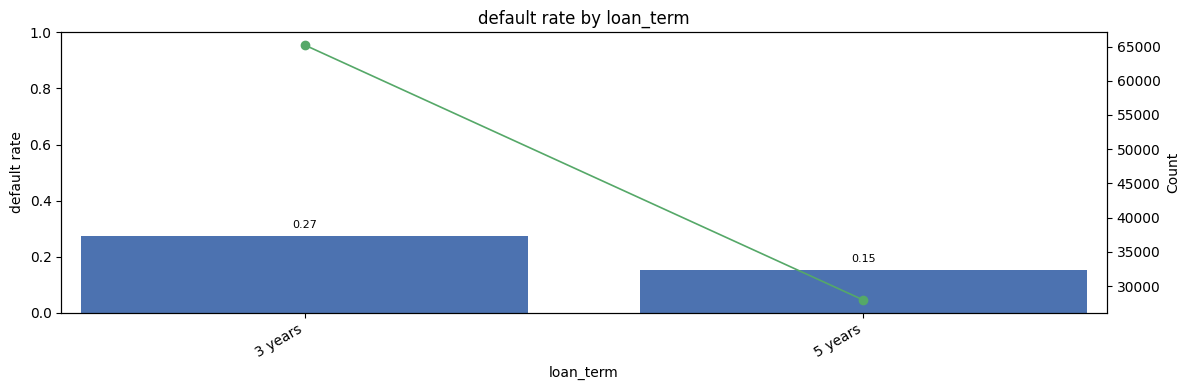

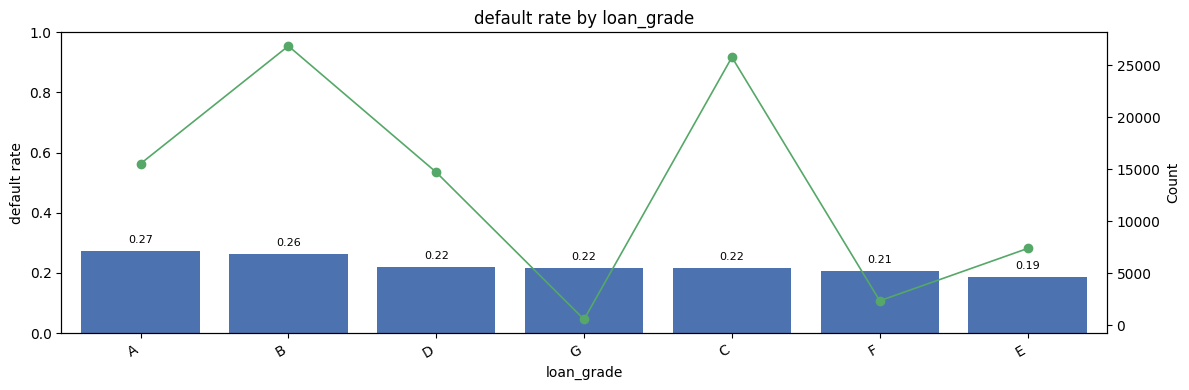

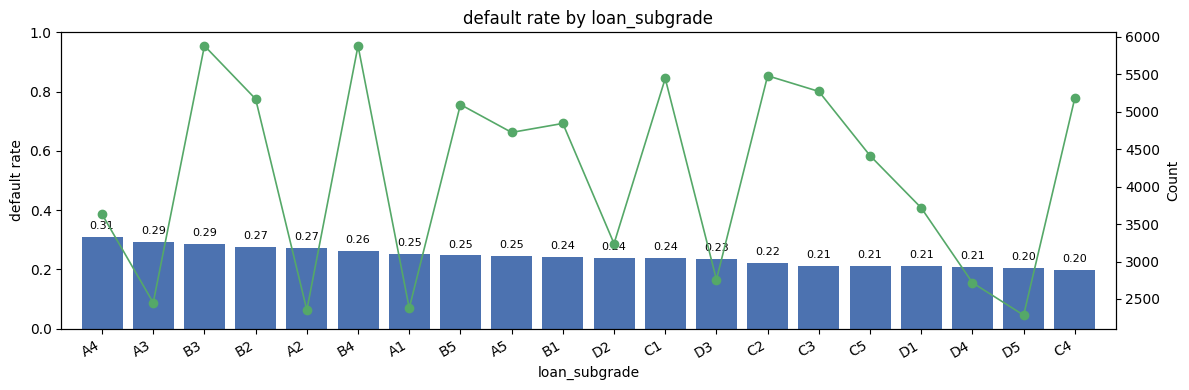

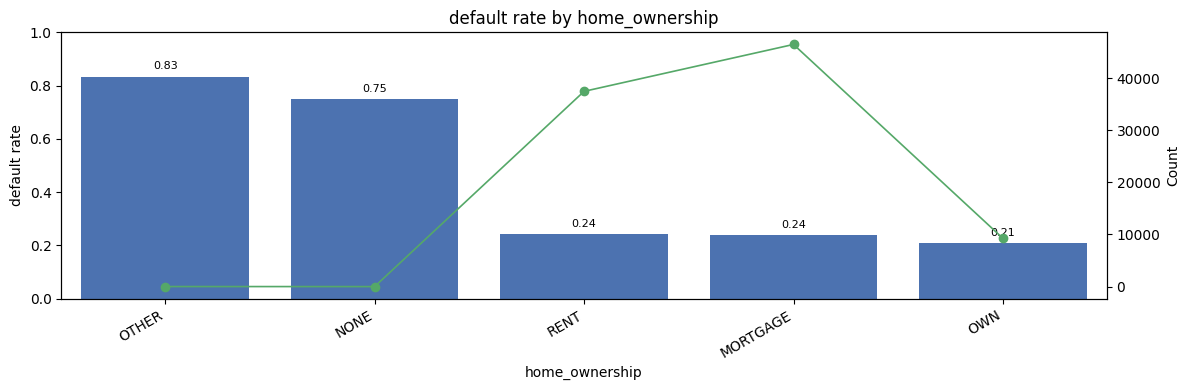

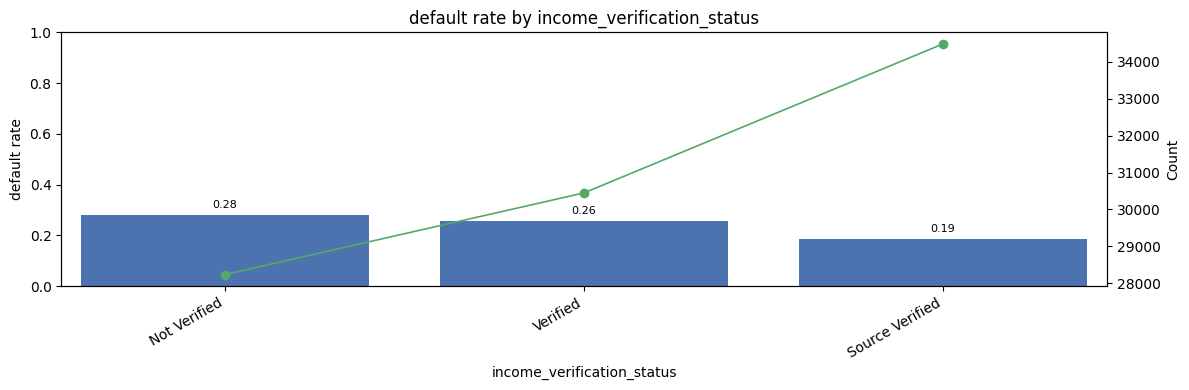

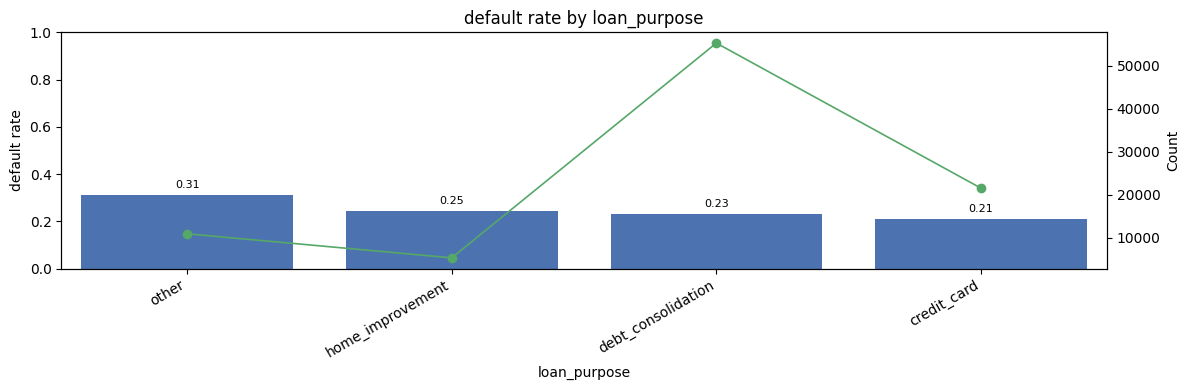

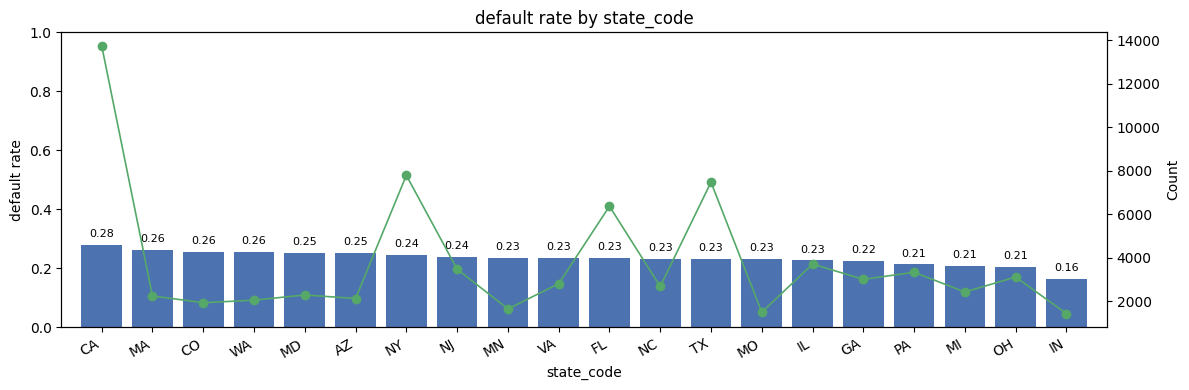

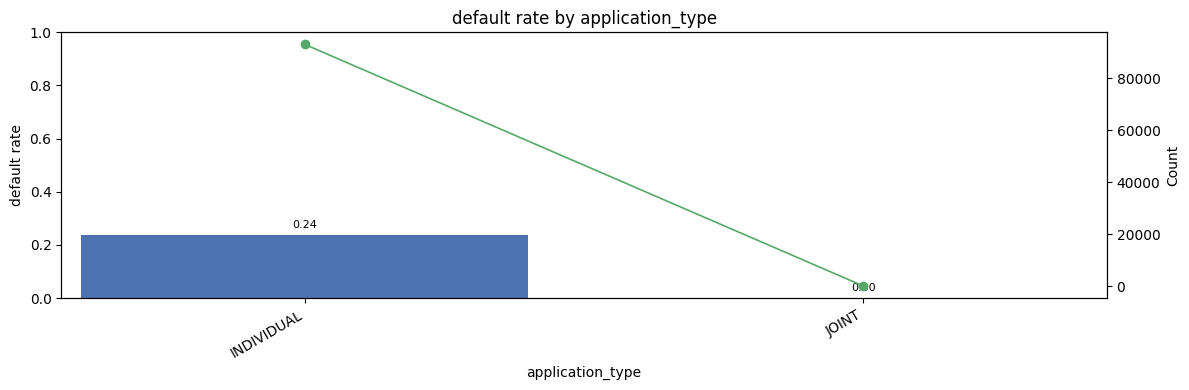

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cat_rate(df, cat_cols, target, top_k=20):
    for col in cat_cols:
        # Ensure categorical dtype for speed and stable ordering [web:62]
        if df[col].dtype != "category":
            df[col] = df[col].astype("category")

        # Precompute counts and rate in one pass [web:68]
        agg = (
            df.groupby(col, observed=True)[target]
              .agg(rate="mean", count="size")
              .sort_values("rate", ascending=False)
        )

        # Keep top_k by count first to avoid tiny noisy bars, then sort by rate
        top_vals = (
            agg.sort_values("count", ascending=False)
               .head(top_k)
               .sort_values("rate", ascending=False)
        )
        idx = top_vals.index

        # Slice once
        sub = agg.loc[idx]

        # Plot
        fig, ax1 = plt.subplots(figsize=(12, 4))
        bars = ax1.bar(
            x=np.arange(len(sub)),
            height=sub["rate"].values,
            color="#4C72B0",
            width=0.8
        )
        ax1.set_ylabel(f"{target} rate")
        ax1.set_ylim(0, 1)
        ax1.set_xlabel(col)
        ax1.set_title(f"{target} rate by {col}")
        ax1.set_xticks(np.arange(len(sub)))
        ax1.set_xticklabels([str(x) for x in sub.index], rotation=30, ha="right")

        # Annotate bars (clipped within axes)
        for i, v in enumerate(sub["rate"].values):
            ax1.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=8)

        # Secondary axis for counts [web:70][web:73]
        ax2 = ax1.twinx()
        ax2.plot(
            np.arange(len(sub)),
            sub["count"].values,
            color="#55A868",
            marker="o",
            linewidth=1.2
        )
        ax2.set_ylabel("Count")

        # Improve layout
        ax1.margins(x=0.02)
        fig.tight_layout()
        plt.show()

plot_cat_rate(train, cat_cols, TARGET, top_k=20)

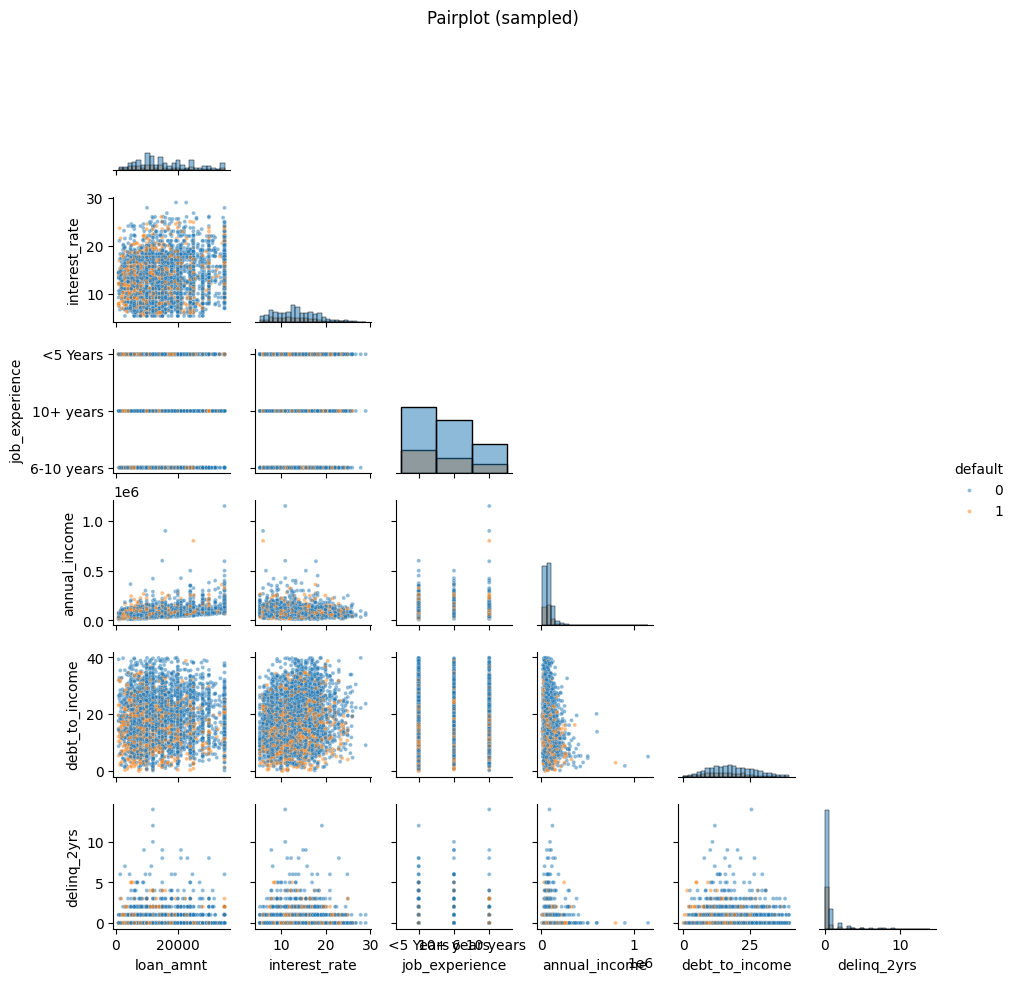

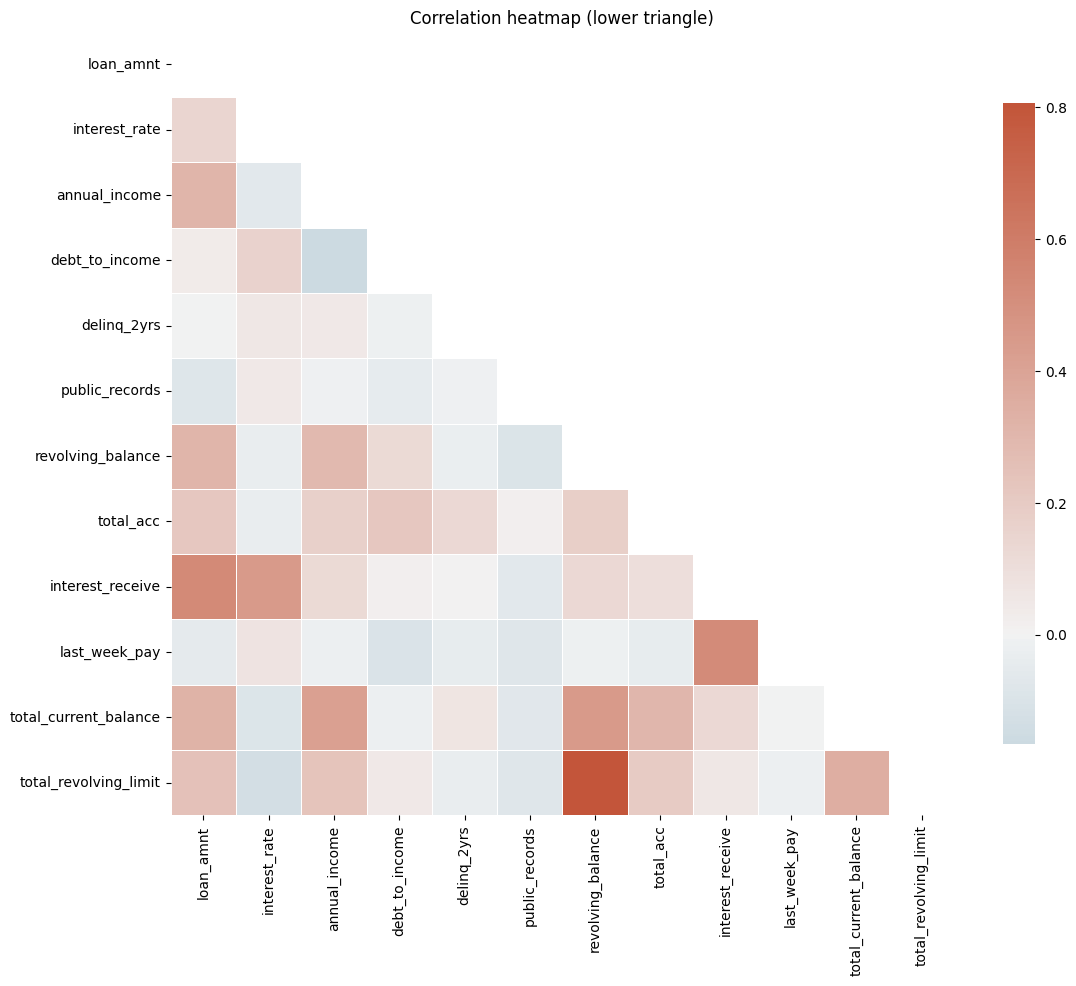

In [50]:
from seaborn import pairplot

pair_cols = num_cols[:6]
pp_sample = train[pair_cols + [TARGET]].dropna()

# cap sample for speed and reduce overplotting
pp_sample = pp_sample.sample(min(len(pp_sample), 4000), random_state=SEED)

g = pairplot(
    pp_sample,
    vars=pair_cols,
    hue=TARGET,                 # include target if categorical
    corner=True,                # show only lower triangle [web:76]
    diag_kind="hist",           # faster than kde for many points [web:76]
    plot_kws={"s": 8, "alpha": 0.5},  # smaller, transparent points [web:76]
    diag_kws={"bins": 24},
    height=1.6,                 # smaller facets for large grids [web:85]
    palette="tab10"
)
g.fig.suptitle("Pairplot (sampled)", y=1.02)


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = train[num_cols].corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))  # hide upper triangle [web:78]
plt.figure(figsize=(0.9*len(num_cols), 0.9*len(num_cols)))
sns.heatmap(
    corr,
    mask=mask,
    cmap=sns.diverging_palette(230, 20, as_cmap=True),  # balanced diverging palette [web:78]
    center=0,
    annot=False,
    square=True,
    linewidths=0.4,
    cbar_kws={"shrink": 0.6}
)
plt.title("Correlation heatmap (lower triangle)")
plt.tight_layout()
plt.show()

In [51]:
X = train[used_features].copy()
y = train["default"].astype(int).copy()
X_test = test[used_features].copy()

In [52]:
def log_rs_per_split(rs, top_n=10):
    # Build a DataFrame from cv_results_ [web:99]
    cv = pd.DataFrame(rs.cv_results_)
    # Identify split columns like 'split0_test_score', ... [web:10]
    split_cols = [c for c in cv.columns if c.startswith("split") and c.endswith("_test_score")]
    base_cols = ["rank_test_score", "mean_test_score", "std_test_score", "params"]

    # Sort by rank and keep top_n
    view = cv[base_cols + split_cols].sort_values("rank_test_score").head(top_n)

    # Pretty print each candidate with its per-fold scores
    for i, row in view.iterrows():
        print(f"\nCandidate rank: {int(row['rank_test_score'])}")
        print(f"Mean score: {row['mean_test_score']:.6f} ± {row['std_test_score']:.6f}")
        print("Params:", row["params"])
        for sc in split_cols:
            print(f"  {sc}: {row[sc]:.6f}")

In [53]:
base_lgb = LGBMClassifier(
    max_depth=-1,  # will be set by search
    random_state=SEED,
    n_jobs=-1,
    force_col_wise=True,
    verbosity=-1
)

pipe_rs = Pipeline(steps=[
    ("prep", preprocess),
    ("model", base_lgb)
])

# Safe global ranges (num_leaves kept moderate; depth widened)
param_dist = {
    "model__max_depth": [6, 7, 8, 9, 10],                         # earlier depth control [web:1]
    "model__num_leaves": randint(20, 160),                        # keep << 2^max_depth globally [web:1][web:3]
    "model__min_child_samples": randint(50, 300),                 # stronger regularization [web:1]
    "model__min_split_gain": uniform(0.0, 0.3),                   # conservative splits [web:4]
    "model__subsample": uniform(0.4, 0.2),                        # ~[0.4, 0.6] [web:4]
    "model__subsample_freq": [1, 2, 3],                           # enable subsampling [web:4]
    "model__colsample_bytree": uniform(0.4, 0.3),                 # ~[0.4, 0.7], widen if many features [web:4]
    "model__reg_alpha": uniform(0.0, 0.3),                        # allow stronger L1 [web:4]
    "model__reg_lambda": uniform(0.0, 0.6),                       # allow stronger L2 [web:4]
    "model__learning_rate": uniform(0.005, 0.045),                # smaller LR needs more trees [web:4][web:5]
    "model__n_estimators": randint(800, 4000),                    # support small LR [web:4]
}

cv_rs = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

rs = RandomizedSearchCV(
    estimator=pipe_rs,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",          # keep accuracy if it’s the KPI; consider roc_auc/balanced_accuracy for search [web:13]
    cv=cv_rs,
    verbose=2,
    n_jobs=-1,
    random_state=SEED,
    refit=True,
    return_train_score=False
)

from sklearn.utils.class_weight import compute_sample_weight
sw_full = compute_sample_weight(class_weight="balanced", y=y)  # do not combine with is_unbalance/scale_pos_weight [web:12][web:9]

rs.fit(X, y, model__sample_weight=sw_full)  # correct Pipeline dunder routing [web:10][web:35]
log_rs_per_split(rs, top_n=10)

print("Best accuracy (CV):", rs.best_score_)
print("Best params:", rs.best_params_)
best_pipe = rs.best_estimator_

best_params = rs.best_params_.copy()
md = best_params.get("model__max_depth", -1)
nl = best_params.get("model__num_leaves", None)
if md is not None and md >= 0 and nl is not None:
    max_leaves_allowed = 2 ** md  # LightGBM warning relates to this bound [web:3]
    if nl > max_leaves_allowed:
        best_params["model__num_leaves"] = max_leaves_allowed

pipe_best = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LGBMClassifier(random_state=SEED, n_jobs=-1, force_col_wise=True, verbosity=-1))
])
pipe_best.set_params(**best_params)


oof_preds = np.zeros(len(train), dtype=float)
oof_thr  = np.zeros(len(train), dtype=float)
test_preds = np.zeros(len(test), dtype=float)
fold_acc = []
fold_best_thr = []

for fold, (tr_idx, va_idx) in enumerate(cv_rs.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]
    sw = compute_sample_weight("balanced", y_tr)

    pipe_best.fit(X_tr, y_tr, model__sample_weight=sw)
    proba_va = pipe_best.predict_proba(X_va)[:, 1]

    # Search thresholds to maximize validation accuracy [web:24]
    thresholds = np.linspace(0.01, 0.99, 99)
    accs = [accuracy_score(y_va, (proba_va >= t).astype(int)) for t in thresholds]
    t_star = thresholds[int(np.argmax(accs))]
    fold_best_thr.append(t_star)

    # store OOF with tuned threshold for reporting
    oof_preds[va_idx] = proba_va
    oof_thr[va_idx] = t_star
    fold_acc.append(np.max(accs))

    # accumulate test predictions (average probabilities) [web:22]
    test_preds += pipe_best.predict_proba(X_test)[:, 1] / cv_rs.n_splits

print("Fold accuracies (tuned thr):", np.round(fold_acc, 4), "Mean:", float(np.mean(fold_acc)))

# Final threshold: average of fold-wise best or re-tune on full train via nested split [web:21]
final_threshold = float(np.mean(fold_best_thr))
print("Chosen final threshold:", final_threshold)

# Final predictions
y_test_pred = (test_preds >= final_threshold).astype(int)

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Candidate rank: 1
Mean score: 0.863299 ± 0.001179
Params: {'model__colsample_bytree': np.float64(0.5123620356542088), 'model__learning_rate': np.float64(0.047782143788446224), 'model__max_depth': 8, 'model__min_child_samples': 121, 'model__min_split_gain': np.float64(0.17959754525911098), 'model__n_estimators': 2438, 'model__num_leaves': 141, 'model__reg_alpha': np.float64(0.04679835610086079), 'model__reg_lambda': np.float64(0.03485016730091967), 'model__subsample': np.float64(0.573235229154987), 'model__subsample_freq': 3}
  split0_test_score: 0.863932
  split1_test_score: 0.864318
  split2_test_score: 0.861646

Candidate rank: 2
Mean score: 0.853189 ± 0.001352
Params: {'model__colsample_bytree': np.float64(0.4873687420594126), 'model__learning_rate': np.float64(0.03253338026250707), 'model__max_depth': 7, 'model__min_child_samples': 269, 'model__min_split_gain': np.float64(0.29212665565243773), 'model__n_estimators': 2606,

In [54]:
# Define threshold grid
thr_grid = np.linspace(0.3, 0.7, 81)

# Store results for all thresholds
threshold_results = []

for thr in thr_grid:
    pred = (oof_preds >= thr).astype(int)
    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred, zero_division=0)
    rec = recall_score(y, pred, zero_division=0)
    f1 = f1_score(y, pred, zero_division=0)

    threshold_results.append({
        "threshold": thr,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

# Convert to DataFrame for easy analysis
df_thresholds = pd.DataFrame(threshold_results)

# Find best threshold by accuracy
best_idx = df_thresholds["accuracy"].idxmax()
best_thr = df_thresholds.loc[best_idx, "threshold"]
best_oof_acc = df_thresholds.loc[best_idx, "accuracy"]
best_prec = df_thresholds.loc[best_idx, "precision"]
best_rec = df_thresholds.loc[best_idx, "recall"]
best_f1 = df_thresholds.loc[best_idx, "f1"]

# Print best threshold and metrics
print("="*60)
print("BEST THRESHOLD RESULTS FOR LGBMClassifier")
print("="*60)
print(f"Best Threshold:  {best_thr:.4f}")
print(f"Best Accuracy:   {best_oof_acc:.6f}")
print(f"Precision:       {best_prec:.6f}")
print(f"Recall:          {best_rec:.6f}")
print(f"F1-Score:        {best_f1:.6f}")
print("="*60)

# Display top 5 thresholds by accuracy
print("\nTop 5 Thresholds by Accuracy:")
top_5 = df_thresholds.nlargest(5, "accuracy")[["threshold", "accuracy", "precision", "recall", "f1"]]
print(top_5.to_string(index=False))

BEST THRESHOLD RESULTS FOR LGBMClassifier
Best Threshold:  0.6050
Best Accuracy:   0.866926
Precision:       0.767926
Recall:          0.630123
F1-Score:        0.692233

Top 5 Thresholds by Accuracy:
 threshold  accuracy  precision   recall       f1
     0.605  0.866926   0.767926 0.630123 0.692233
     0.625  0.866926   0.776987 0.616702 0.687628
     0.635  0.866883   0.781424 0.610195 0.685275
     0.590  0.866873   0.761354 0.640110 0.695488
     0.610  0.866862   0.769811 0.626870 0.691026


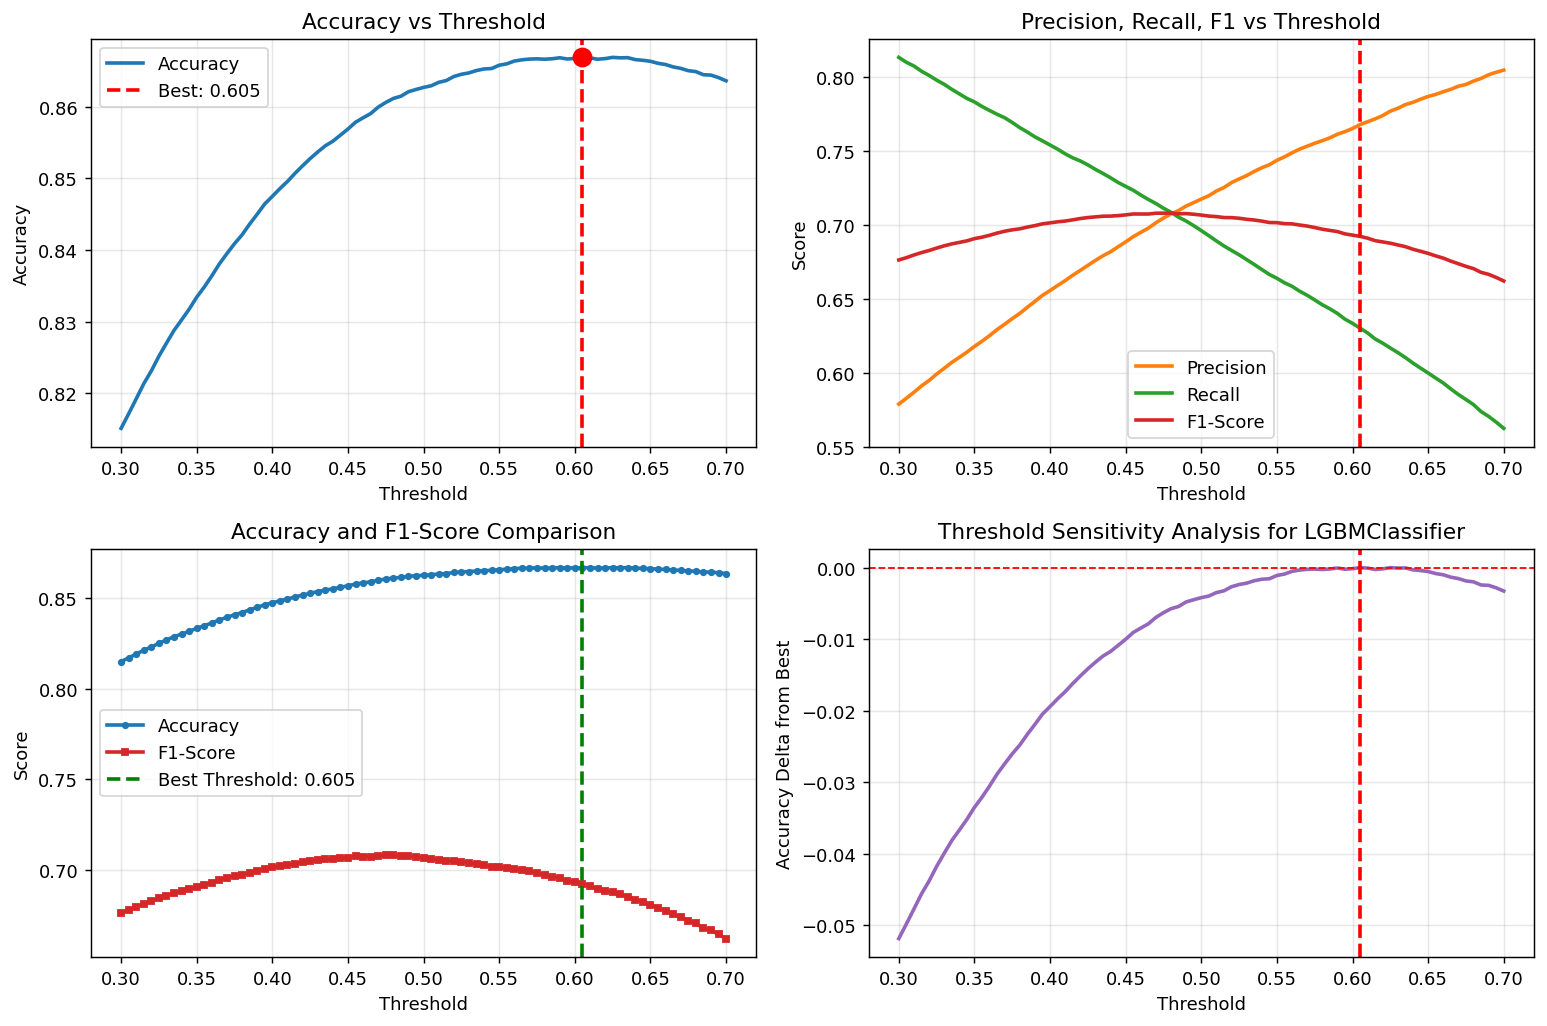

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=130)

# Plot 1: Accuracy curve
axes[0, 0].plot(df_thresholds["threshold"], df_thresholds["accuracy"],
                linewidth=2, color="#1f77b4", label="Accuracy")
axes[0, 0].axvline(best_thr, color="red", linestyle="--", linewidth=2, label=f"Best: {best_thr:.3f}")
axes[0, 0].scatter([best_thr], [best_oof_acc], color="red", s=100, zorder=5)
axes[0, 0].set_xlabel("Threshold")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_title("Accuracy vs Threshold")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Precision, Recall, F1
axes[0, 1].plot(df_thresholds["threshold"], df_thresholds["precision"],
                linewidth=2, label="Precision", color="#ff7f0e")
axes[0, 1].plot(df_thresholds["threshold"], df_thresholds["recall"],
                linewidth=2, label="Recall", color="#2ca02c")
axes[0, 1].plot(df_thresholds["threshold"], df_thresholds["f1"],
                linewidth=2, label="F1-Score", color="#d62728")
axes[0, 1].axvline(best_thr, color="red", linestyle="--", linewidth=2)
axes[0, 1].set_xlabel("Threshold")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_title("Precision, Recall, F1 vs Threshold")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Accuracy and F1 together
axes[1, 0].plot(df_thresholds["threshold"], df_thresholds["accuracy"],
                linewidth=2, label="Accuracy", color="#1f77b4", marker="o", markersize=3)
axes[1, 0].plot(df_thresholds["threshold"], df_thresholds["f1"],
                linewidth=2, label="F1-Score", color="#d62728", marker="s", markersize=3)
axes[1, 0].axvline(best_thr, color="green", linestyle="--", linewidth=2,
                   label=f"Best Threshold: {best_thr:.3f}")
axes[1, 0].set_xlabel("Threshold")
axes[1, 0].set_ylabel("Score")
axes[1, 0].set_title("Accuracy and F1-Score Comparison")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Plot 4: Threshold sensitivity (delta from best)
axes[1, 1].plot(df_thresholds["threshold"],
                df_thresholds["accuracy"] - best_oof_acc,
                linewidth=2, color="#9467bd")
axes[1, 1].axhline(0, color="red", linestyle="--", linewidth=1)
axes[1, 1].axvline(best_thr, color="red", linestyle="--", linewidth=2)
axes[1, 1].set_xlabel("Threshold")
axes[1, 1].set_ylabel("Accuracy Delta from Best")
axes[1, 1].set_title("Accuracy Sensitivity to Threshold Changes")
axes[1, 1].grid(True, alpha=0.3)

plt.title("Threshold Sensitivity Analysis for LGBMClassifier")
plt.tight_layout()
plt.show()


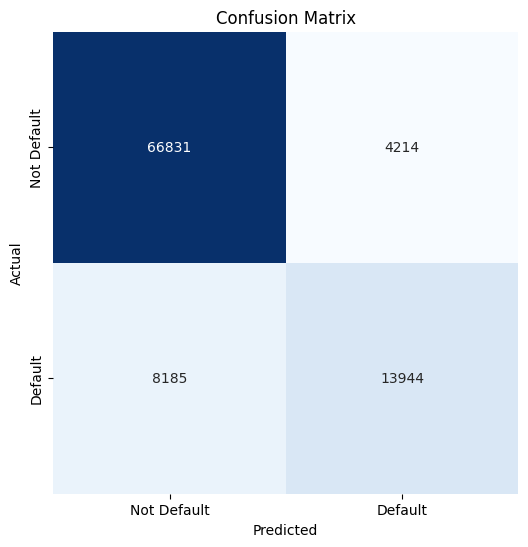

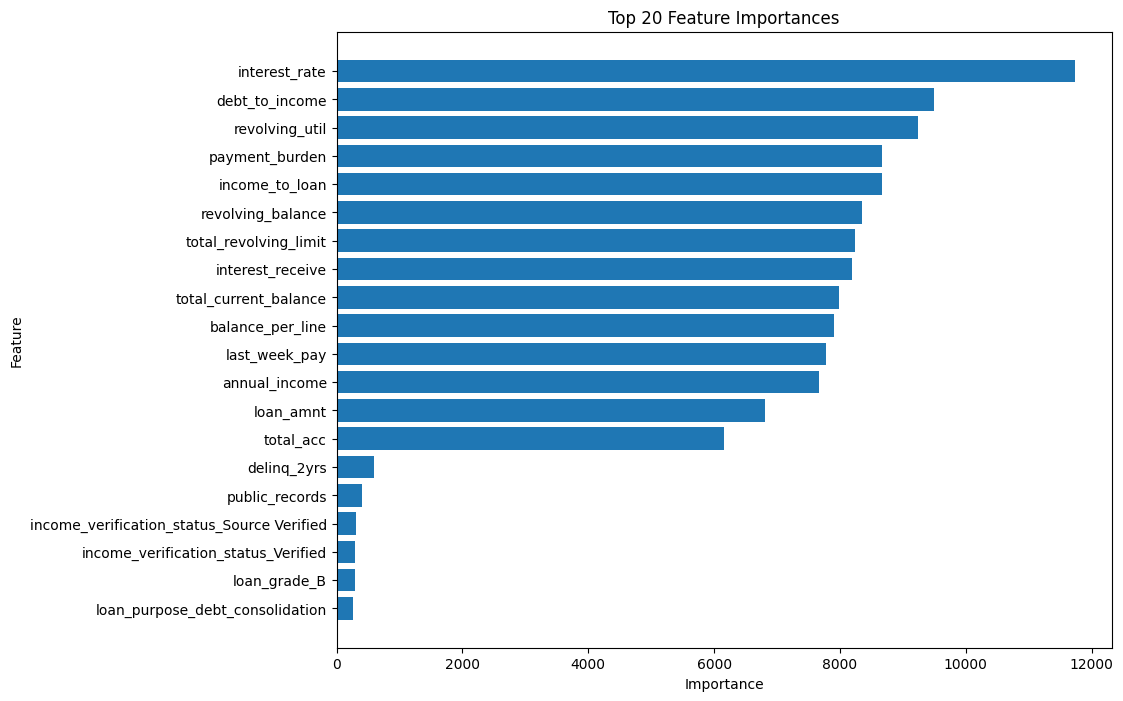

In [56]:
# Confusion Matrix
conf_matrix = confusion_matrix(y, (oof_preds >= best_thr).astype(int))
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Default", "Default"], yticklabels=["Not Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Feature Importances

feature_importance = pipe_best.named_steps["model"].feature_importances_
# Correctly get feature names from the ColumnTransformer step
feature_names = pipe_best.named_steps["prep"].named_steps["columnwise"].get_feature_names_out()
feature_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
feature_imp_df = feature_imp_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_imp_df["Feature"][:20], feature_imp_df["Importance"][:20]) # Plot top 20 for clarity
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis() # Display most important at the top
plt.show()

In [57]:
test_pred = (test_preds >= best_thr).astype(int)

submission = pd.DataFrame({
    "ID": test["ID"].values,
    "default": test_pred
})

# If platform allows any ID order, this is fine; otherwise sort by ID
# submission = submission.sort_values("ID")

print(f"\nSubmission Summary:")
print(f"Total rows: {len(submission)}")
print(f"Default=1 count: {submission['default'].sum()}")
print(f"Default=0 count: {(submission['default']==0).sum()}")
print(f"Default rate: {submission['default'].mean():.4f}")
print(submission.head(10))

print("Rows:", len(submission))
submission.to_csv(SUBMIT_PATH, index=False)
print(f"Saved -> {SUBMIT_PATH}")



Submission Summary:
Total rows: 39933
Default=1 count: 7584
Default=0 count: 32349
Default rate: 0.1899
         ID  default
0   4855329        1
1  66862420        0
2   3637416        1
3  53682249        0
4  53937165        0
5   1464149        1
6   7429943        1
7  10047245        1
8  46816125        0
9  57125517        0
Rows: 39933
Saved -> submission_lgbm.csv


In [58]:
# Quick label balance check
print("Train target rate (mean):", y.mean())
print("Submission 1-rate:", submission["default"].mean())

Train target rate (mean): 0.2375018782063666
Submission 1-rate: 0.18991811283900534


In [59]:
!pip install catboost

In [60]:
# Reuse used_features, num_cols, cat_cols, X, y, X_test from earlier cells.
# IMPORTANT: Ensure earlier parsing of job_experience and last_week_pay is applied if present.

# CatBoost expects categorical indices relative to the provided feature order
feature_order = used_features[:]  # keep a stable order
cat_idx = [feature_order.index(c) for c in cat_cols if c in feature_order]

X_cb = train[feature_order].copy()
X_test_cb = test[feature_order].copy()
y_cb = y.copy()

# Optional: simple numeric capping to stabilize trees (keeps behavior similar to LGBM block)
for df in (X_cb, X_test_cb):
    for c in num_cols:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce")
            lo, hi = np.nanpercentile(s.dropna(), 1), np.nanpercentile(s.dropna(), 99)
            df[c] = s.clip(lo, hi)


/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1633: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1633: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Rank: 1  Mean: 0.87947 ± 0.00083
Params: {'depth': 9, 'iterations': 3633, 'l2_leaf_reg': np.float64(4.4546743769349115), 'leaf_estimation_iterations': 21, 'learning_rate': np.float64(0.03278666793324724)}
  split0_test_score: 0.87961
  split1_test_score: 0.88042
  split2_test_score: 0.87839

Rank: 2  Mean: 0.87073 ± 0.00191
Params: {'depth': 7, 'iterations': 2060, 'l2_leaf_reg': np.float64(4.485261007457112), 'leaf_estimation_iterations': 8, 'learning_rate': np.float64(0.03193963178886665)}
  split0_test_score: 0.86892
  split1_test_score: 0.87337
  split2_test_score: 0.86989

Rank: 3  Mean: 0.86501 ± 0.00368
Params: {'depth': 7, 'iterations': 1330, 'l2_leaf_reg': np.float64(1.3911053916202465), 'leaf_estimation_iterations': 2, 'learning_rate': np.float64(0.03748994475200711)}
  split0_test_score: 0.86071
  split1_test_score: 0.86970
  split2_test_score: 0.86461

Rank: 4  Mean: 0.86218 ± 0.00229
Params: {'depth': 5, 'iteratio

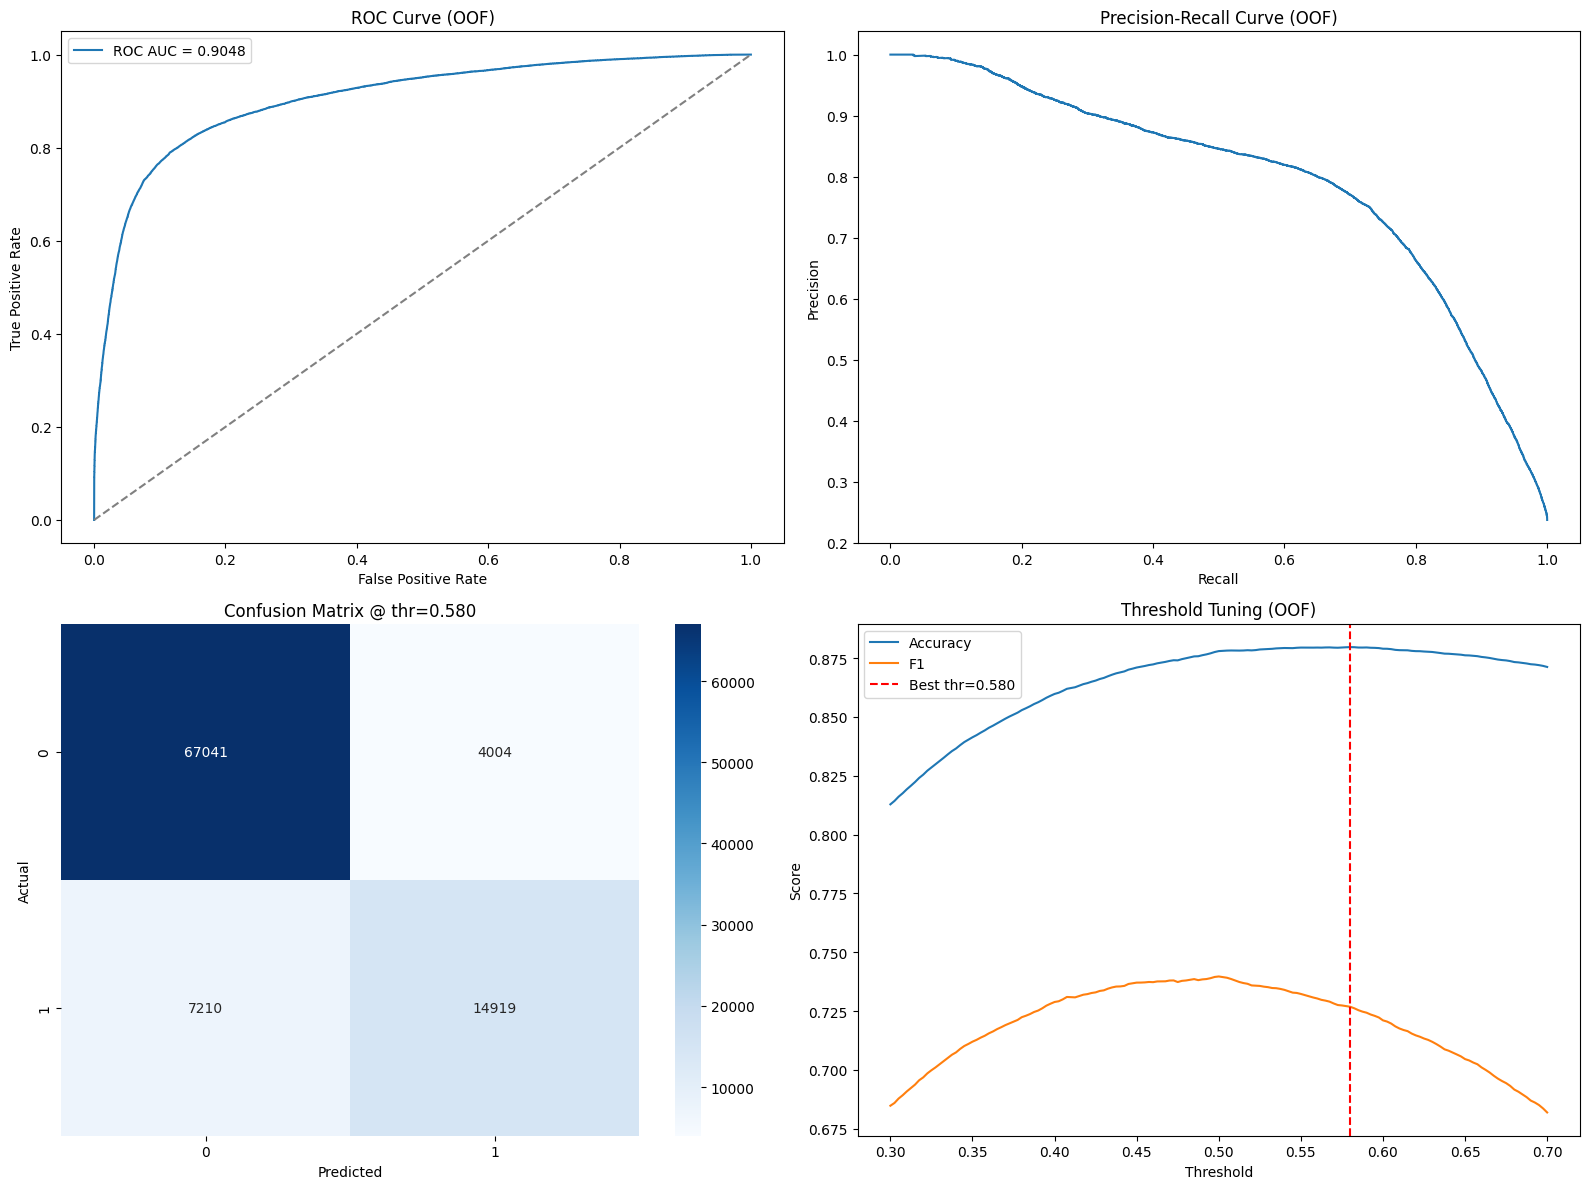

In [61]:
# 0) Imports & CV
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from scipy.stats import randint, uniform

# assume: X_cb, y_cb, X_test_cb, cat_idx, SEED, K_FOLD_COUNT, N_ITER_COUNT defined

skf = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

# 1) Base params: faster training, early stopping enabled
base_params = dict(
    loss_function="Logloss",
    eval_metric="Accuracy",
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_seed=SEED,
    od_type="Iter",
    od_wait=200,                 # extend patience for stability
    allow_writing_files=False,
    verbose=False
)

# 2) Estimator and widened search space
cb_sklearn = CatBoostClassifier(**base_params)

param_dist = {
    "iterations": randint(1200, 4000),     # allow more trees for small LR
    "learning_rate": uniform(0.005, 0.045),# ~[0.005, 0.05]
    "depth": randint(4, 10),               # explore deeper trees if needed
    "l2_leaf_reg": uniform(1.0, 19.0),     # ~[1, 20]
    "leaf_estimation_iterations": randint(1, 25)
}

# 3) Global sample weights for CV
sw_global = compute_sample_weight(class_weight="balanced", y=y_cb)

# 4) Randomized search with per-fold eval_set + sample_weight
rand_search = RandomizedSearchCV(
    estimator=cb_sklearn,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",
    n_jobs=-1,
    cv=skf,
    random_state=SEED,
    verbose=2,
    refit=True
)

# Important: pass cat_features and sample_weight in fit; CatBoost will use eval_set per CV split internally
rand_search.fit(
    X_cb, y_cb,
    cat_features=cat_idx,
    sample_weight=sw_global
)

# Optional: inspect split-wise results
def log_rs_per_split(rs, top_n=10):
    cv = pd.DataFrame(rs.cv_results_)
    split_cols = [c for c in cv.columns if c.startswith("split") and c.endswith("_test_score")]
    view = cv[["rank_test_score", "mean_test_score", "std_test_score", "params"] + split_cols] \
             .sort_values("rank_test_score").head(top_n)
    for _, row in view.iterrows():
        print(f"\nRank: {int(row['rank_test_score'])}  Mean: {row['mean_test_score']:.5f} ± {row['std_test_score']:.5f}")
        print("Params:", row["params"])
        for sc in split_cols:
            print(f"  {sc}: {row[sc]:.5f}")

log_rs_per_split(rand_search, top_n=10)
print("Best params:", rand_search.best_params_)
print("Best CV accuracy:", rand_search.best_score_)

# 5) Merge tuned params
cb_params = {**base_params, **rand_search.best_params_}

# 6) Cross-validated OOF with per-fold early stopping and weights
oof_cb = np.zeros(len(X_cb), dtype=float)
test_cb = np.zeros(len(X_test_cb), dtype=float)
fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_cb, y_cb), 1):
    X_tr, y_tr = X_cb.iloc[tr_idx], y_cb.iloc[tr_idx]
    X_va, y_va = X_cb.iloc[va_idx], y_cb.iloc[va_idx]
    sw = compute_sample_weight(class_weight="balanced", y=y_tr)

    train_pool = Pool(X_tr, y_tr, cat_features=cat_idx, weight=sw)
    valid_pool = Pool(X_va, y_va, cat_features=cat_idx)

    cb = CatBoostClassifier(**cb_params)
    cb.fit(train_pool, eval_set=valid_pool, use_best_model=True)  # capture best iteration

    va_proba = cb.predict_proba(valid_pool)[:, 1]
    oof_cb[va_idx] = va_proba
    va_pred = (va_proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, va_pred)
    fold_acc.append(acc)
    print(f"Fold {fold} acc@0.5: {acc:.5f}")

    test_cb += cb.predict_proba(Pool(X_test_cb, cat_features=cat_idx))[:, 1] / skf.n_splits

print("CatBoost fold accuracies:", np.round(fold_acc, 4), "Mean:", np.mean(fold_acc))

# 7) Threshold tuning on OOF for max accuracy
thr_grid = np.linspace(0.3, 0.7, 161)
best_thr = max(thr_grid, key=lambda t: accuracy_score(y_cb, (oof_cb >= t).astype(int)))
best_acc_cb = accuracy_score(y_cb, (oof_cb >= best_thr).astype(int))
print("Best OOF accuracy (CatBoost):", round(best_acc_cb, 6), "at threshold:", round(best_thr, 3))

# 8) Report metrics at 0.5 and tuned threshold
def evaluate_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return dict(
        threshold=float(thr),
        accuracy=accuracy_score(y_true, pred),
        precision=precision_score(y_true, pred, zero_division=0),
        recall=recall_score(y_true, pred, zero_division=0),
        f1=f1_score(y_true, pred, zero_division=0)
    )

metrics_05 = evaluate_at_threshold(y_cb, oof_cb, 0.5)
metrics_best = evaluate_at_threshold(y_cb, oof_cb, best_thr)
print("Metrics @0.5:", metrics_05)
print("Metrics @best:", metrics_best)

# 9) Confusion matrices
cm_05 = confusion_matrix(y_cb, (oof_cb >= 0.5).astype(int))
cm_best = confusion_matrix(y_cb, (oof_cb >= best_thr).astype(int))
print("Confusion @0.5:\n", cm_05)
print("Confusion @best:\n", cm_best)

# 10) Curves and threshold sweep
roc_auc = roc_auc_score(y_cb, oof_cb)
fpr, tpr, _ = roc_curve(y_cb, oof_cb)
prec, rec, _ = precision_recall_curve(y_cb, oof_cb)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)"); plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve (OOF)")

plt.subplot(2, 2, 3)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ thr={best_thr:.3f}")

plt.subplot(2, 2, 4)
accs = [accuracy_score(y_cb, (oof_cb >= t).astype(int)) for t in thr_grid]
f1s  = [f1_score(y_cb, (oof_cb >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs, label="Accuracy")
plt.plot(thr_grid, f1s, label="F1")
plt.axvline(best_thr, color="red", linestyle="--", label=f"Best thr={best_thr:.3f}")
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("Threshold Tuning (OOF)"); plt.legend()

plt.tight_layout(); plt.show()

In [62]:
test_pred_cat = (test_cb >= best_thr).astype(int)
submission_cb = pd.DataFrame({
    "ID": test["ID"].values,
    "default": test_pred_cat
})

print(submission_cb.head())
print("Rows:", len(submission_cb))
submission_cb.to_csv("submission_catboost.csv", index=False)
print("Saved -> submission_catboost.csv")


         ID  default
0   4855329        1
1  66862420        0
2   3637416        1
3  53682249        0
4  53937165        0
Rows: 39933
Saved -> submission_catboost.csv


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Rank: 1  Mean: 0.77973 ± 0.00178
Params: {'model__method': 'sigmoid', 'model__estimator__C': np.float64(2.636650898730358)}
  split0_test_score: 0.77835
  split1_test_score: 0.78225
  split2_test_score: 0.77861

Rank: 2  Mean: 0.77937 ± 0.00117
Params: {'model__method': 'sigmoid', 'model__estimator__C': np.float64(0.12742749857031335)}
  split0_test_score: 0.77851
  split1_test_score: 0.78102
  split2_test_score: 0.77858

Rank: 3  Mean: 0.77928 ± 0.00170
Params: {'model__method': 'isotonic', 'model__estimator__C': np.float64(0.23357214690901212)}
  split0_test_score: 0.77716
  split1_test_score: 0.78131
  split2_test_score: 0.77938

Rank: 4  Mean: 0.77841 ± 0.00103
Params: {'model__method': 'isotonic', 'model__estimator__C': np.float64(0.06951927961775606)}
  split0_test_score: 0.77780
  split1_test_score: 0.77986
  split2_test_score: 0.77758

Rank: 5  Mean: 0.77817 ± 0.00077
Params: {'model__method': 'sigmoid', 'model__estim

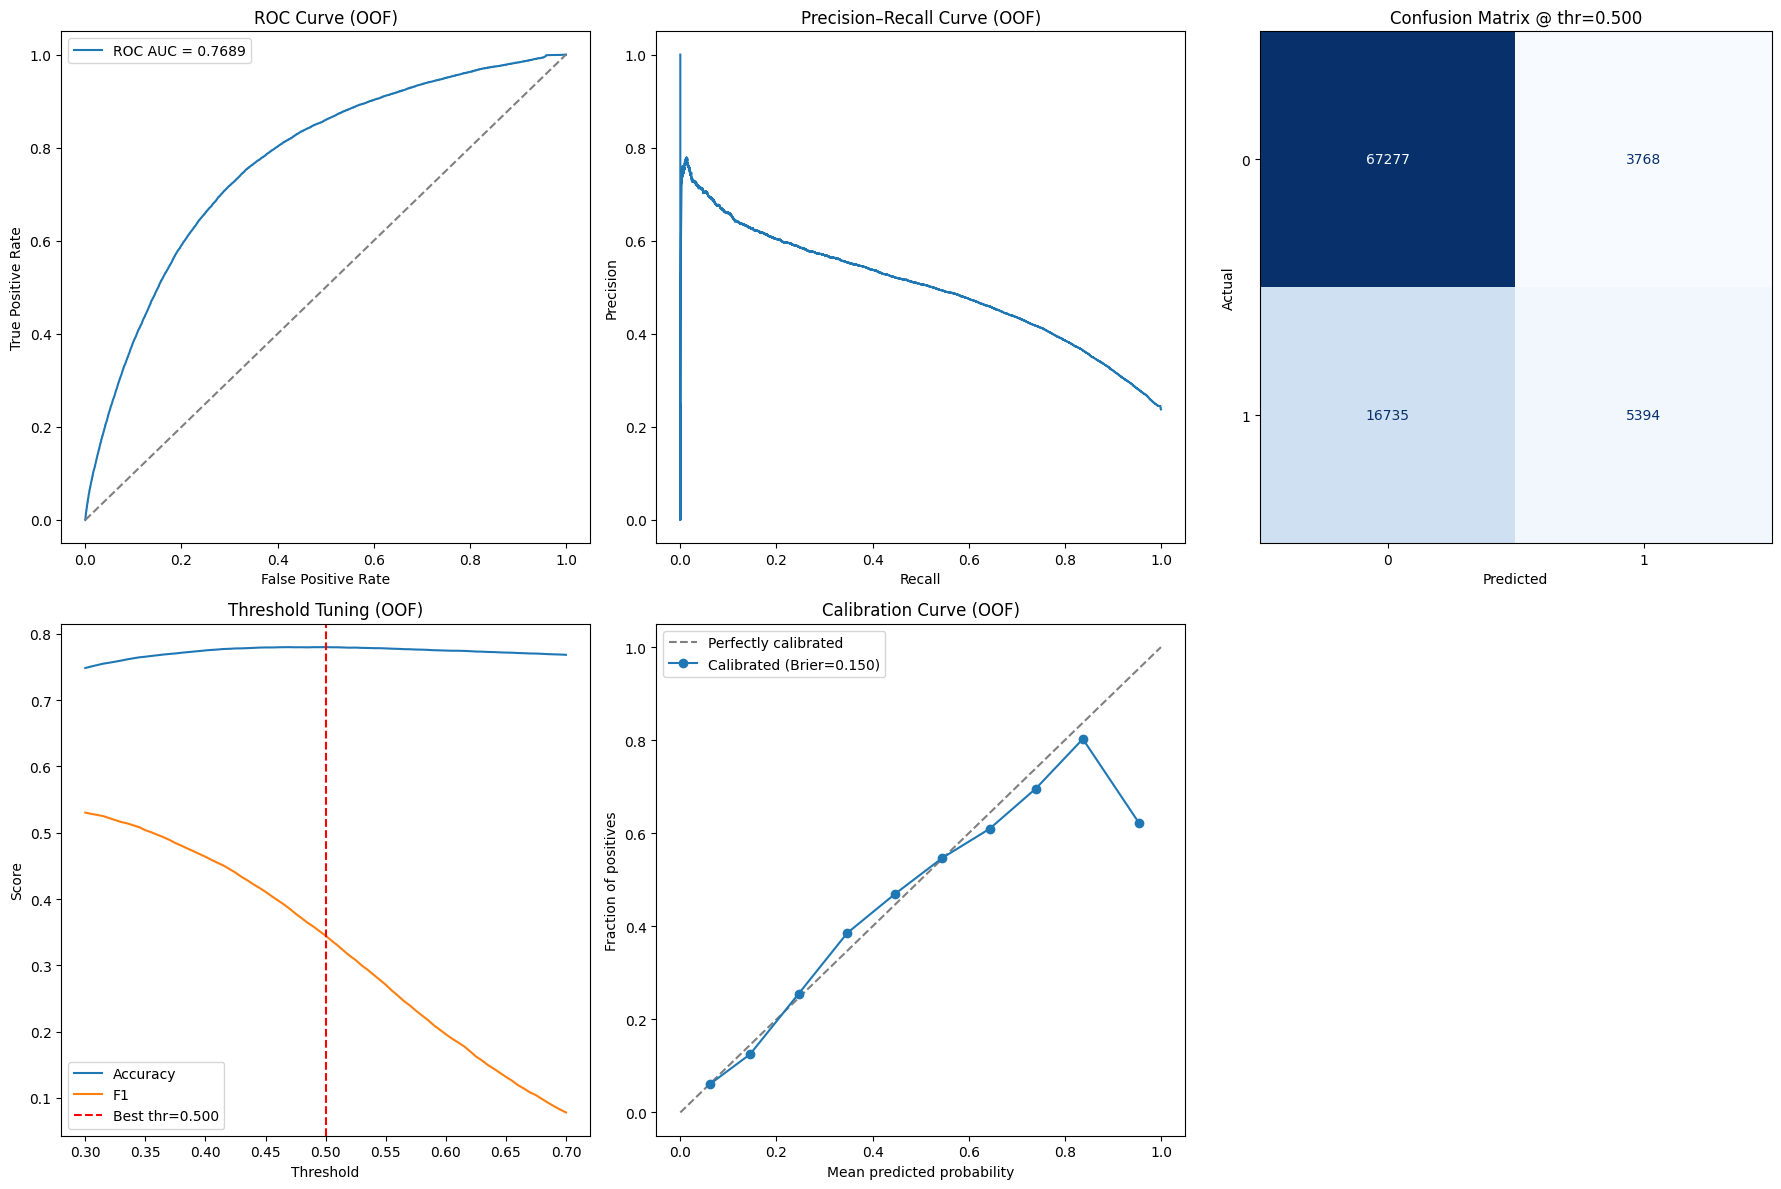

Saved -> submission_svm.csv


In [64]:
# Prereqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    brier_score_loss
)

# Base LinearSVC with balanced class weights
svm_base = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=10000,
    random_state=SEED,
)

# Calibrate to obtain calibrated predict_proba
svm_clf = CalibratedClassifierCV(
    estimator=svm_base,   # estimator is correct parameter name
    method="sigmoid",     # Platt scaling
    cv=3                  # internal CV for calibration
)

# Pipeline with preprocessing
svm_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", svm_clf)
])

skf = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

# Hyperparameter search over C for LinearSVC via the calibrated wrapper
# Use model__estimator__<param> to reach the LinearSVC inside CalibratedClassifierCV
param_dist = {
    "model__estimator__C": np.logspace(-3, 2, 20),     # 0.001 to 100
    "model__method": ["sigmoid", "isotonic"],          # compare Platt vs isotonic
}

rand_search = RandomizedSearchCV(
    estimator=svm_pipe,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",
    n_jobs=-1,
    cv=skf,
    random_state=SEED,
    verbose=3,
    refit=True
)

rand_search.fit(X, y)
log_rs_per_split(rand_search, top_n=10)
print("Best params:", rand_search.best_params_)
print("Best CV accuracy:", rand_search.best_score_)

best_pipe = rand_search.best_estimator_

# Cross-validated OOF predictions
oof_svm = np.zeros(len(train), dtype=float)
test_svm = np.zeros(len(test), dtype=float)
fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    # Clone best config per fold
    fold_pipe = Pipeline(steps=[
        ("prep", best_pipe.named_steps["prep"]),
        ("model", CalibratedClassifierCV(
            estimator=LinearSVC(**best_pipe.named_steps["model"].estimator.get_params()),
            method=best_pipe.named_steps["model"].method,
            cv=best_pipe.named_steps["model"].cv
        ))
    ])

    fold_pipe.fit(X_tr, y_tr)

    proba = fold_pipe.predict_proba(X_va)[:, 1]
    oof_svm[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc.append(acc)

    test_svm += fold_pipe.predict_proba(X_test)[:, 1] / skf.n_splits

print("SVM fold accuracies:", np.round(fold_acc, 4), "Mean:", np.mean(fold_acc))

# Threshold tuning on OOF
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr_svm = max(thr_grid, key=lambda t: accuracy_score(y, (oof_svm >= t).astype(int)))
best_acc_svm = accuracy_score(y, (oof_svm >= best_thr_svm).astype(int))
print("Best OOF accuracy (SVM):", round(best_acc_svm, 6), "at threshold:", round(best_thr_svm, 3))

# Metrics at 0.5 and best threshold
def metrics_at(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return dict(
        threshold=thr,
        accuracy=accuracy_score(y_true, pred),
        precision=precision_score(y_true, pred, zero_division=0),
        recall=recall_score(y_true, pred, zero_division=0),
        f1=f1_score(y_true, pred, zero_division=0)
    )

m05 = metrics_at(y, oof_svm, 0.5)
mbest = metrics_at(y, oof_svm, best_thr_svm)
print("Metrics @0.5:", m05)
print("Metrics @best:", mbest)
print(classification_report(y, (oof_svm >= best_thr_svm).astype(int)))

# Confusion matrices
cm_05 = confusion_matrix(y, (oof_svm >= 0.5).astype(int))
cm_best = confusion_matrix(y, (oof_svm >= best_thr_svm).astype(int))
print("Confusion @0.5:\n", cm_05)
print("Confusion @best:\n", cm_best)

# ROC and PR curves
roc_auc = roc_auc_score(y, oof_svm)
fpr, tpr, _ = roc_curve(y, oof_svm)
prec, rec, _ = precision_recall_curve(y, oof_svm)

# Calibration curve (reliability diagram) and Brier score
prob_true, prob_pred = calibration_curve(y, oof_svm, n_bins=10, strategy="uniform")
brier = brier_score_loss(y, oof_svm)
print(f"Brier score (OOF): {brier:.6f}")

# Plots: ROC, PR, Confusion Matrix @ best thr, Threshold Tuning, Calibration
plt.figure(figsize=(18, 12))

# ROC
plt.subplot(2, 3, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()

# PR
plt.subplot(2, 3, 2)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF)")

# Confusion matrix (best thr)
plt.subplot(2, 3, 3)
disp = ConfusionMatrixDisplay(cm_best)
disp.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_svm:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Threshold tuning (Accuracy & F1)
plt.subplot(2, 3, 4)
accs = [accuracy_score(y, (oof_svm >= t).astype(int)) for t in thr_grid]
f1s = [f1_score(y, (oof_svm >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs, label="Accuracy")
plt.plot(thr_grid, f1s, label="F1")
plt.axvline(best_thr_svm, color="red", linestyle="--", label=f"Best thr={best_thr_svm:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF)")
plt.legend()

# Calibration curve
plt.subplot(2, 3, 5)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, marker="o", label=f"Calibrated (Brier={brier:.3f})")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (OOF)")
plt.legend()

plt.tight_layout()
plt.show()

# Save submission using best threshold
submission_svm = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_svm >= best_thr_svm).astype(int)
})
submission_svm.to_csv("submission_svm.csv", index=False)
print("Saved -> submission_svm.csv")

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Rank: 1  Mean: 0.71211 ± 0.00236
Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': np.float64(9.236708571873866)}
  split0_test_score: 0.71544
  split1_test_score: 0.71070
  split2_test_score: 0.71019

Rank: 2  Mean: 0.71170 ± 0.00343
Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': np.float64(1.2689610031679235)}
  split0_test_score: 0.71630
  split1_test_score: 0.71073
  split2_test_score: 0.70806

Rank: 3  Mean: 0.70559 ± 0.00293
Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': np.float64(0.1743328822199989)}
  split0_test_score: 0.70974
  split1_test_score: 0.70339
  split2_test_score: 0.70365

Rank: 4  Mean: 0.68604 ± 0.00187
Params: {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': np.float64(0.01610262027560939)}
  split0_test_score: 0.68868
  split1_test_score: 0.68459
  split2_test_score: 0.68485

Rank: 5  Mean: 0.66045 ± 0.00065
Params: {'

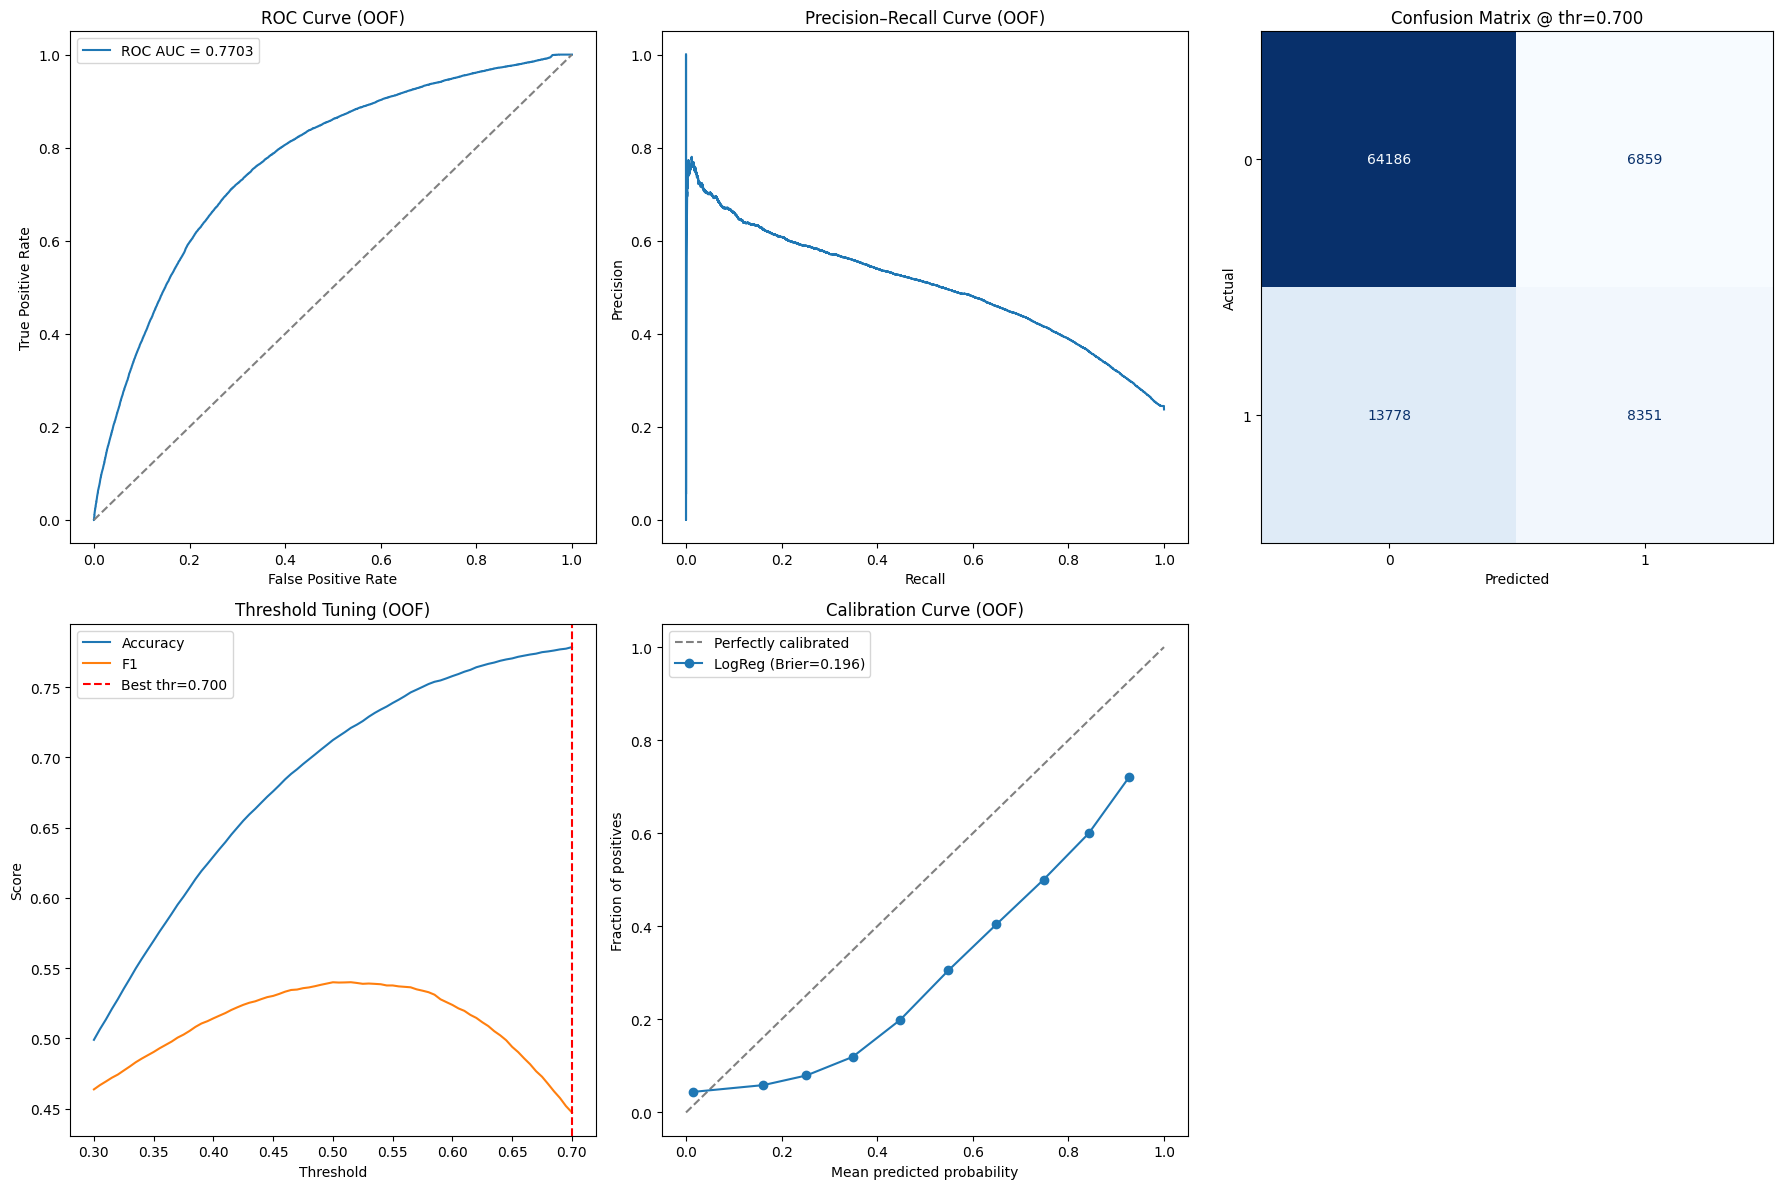

Saved -> submission_logistic_regression.csv


In [65]:
# Prereqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Assumes: X, y, X_test, train, test, preprocess, SEED already defined

# Base Logistic Regression
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight="balanced",
    solver="liblinear",   # try 'saga' for large/sparse; 'lbfgs' for dense
    max_iter=2000,
    random_state=SEED
)

logreg_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", logreg)
])

skf = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

# ---- RandomizedSearchCV over key knobs ----
param_dist = {
    "model__C": np.logspace(-3, 2, 30),             # 0.001 to 100
    "model__solver": ["liblinear", "lbfgs", "saga"],# saga supports L1/L2, sparse
    "model__penalty": ["l2"],                       # keep L2; for L1 use saga only
}
# Optional: include L1 for sparse with saga
# param_dist["model__penalty"] = ["l2", "l1"]
# and ensure solver includes "saga"

rand_search = RandomizedSearchCV(
    estimator=logreg_pipe,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",
    n_jobs=-1,
    cv=skf,
    random_state=SEED,
    verbose=3,
    refit=True
)

rand_search.fit(X, y)
log_rs_per_split(rand_search, top_n=10)
print("Best params:", rand_search.best_params_)
print("Best CV accuracy:", rand_search.best_score_)

best_pipe = rand_search.best_estimator_

# ---- Cross-validated OOF predictions ----
oof_lr = np.zeros(len(train), dtype=float)
test_lr = np.zeros(len(test), dtype=float)
fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    # clone the tuned pipeline per fold
    fold_pipe = Pipeline(steps=[
        ("prep", best_pipe.named_steps["prep"]),
        ("model", LogisticRegression(**best_pipe.named_steps["model"].get_params()))
    ])

    fold_pipe.fit(X_tr, y_tr)

    proba = fold_pipe.predict_proba(X_va)[:, 1]
    oof_lr[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc.append(acc)

    test_lr += fold_pipe.predict_proba(X_test)[:, 1] / skf.n_splits

print("LogReg fold accuracies:", np.round(fold_acc, 4), "Mean:", np.mean(fold_acc))

# ---- Threshold tuning on OOF ----
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr_lr = max(thr_grid, key=lambda t: accuracy_score(y, (oof_lr >= t).astype(int)))
best_acc_lr = accuracy_score(y, (oof_lr >= best_thr_lr).astype(int))
print("Best OOF accuracy (LogReg):", round(best_acc_lr, 6), "at threshold:", round(best_thr_lr, 3))

# ---- Metrics at 0.5 and best threshold ----
def metrics_at(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return dict(
        threshold=thr,
        accuracy=accuracy_score(y_true, pred),
        precision=precision_score(y_true, pred, zero_division=0),
        recall=recall_score(y_true, pred, zero_division=0),
        f1=f1_score(y_true, pred, zero_division=0)
    )

m05 = metrics_at(y, oof_lr, 0.5)
mbest = metrics_at(y, oof_lr, best_thr_lr)
print("Metrics @0.5:", m05)
print("Metrics @best:", mbest)
print(classification_report(y, (oof_lr >= best_thr_lr).astype(int)))

# ---- Confusion matrices ----
cm_05 = confusion_matrix(y, (oof_lr >= 0.5).astype(int))
cm_best = confusion_matrix(y, (oof_lr >= best_thr_lr).astype(int))
print("Confusion @0.5:\n", cm_05)
print("Confusion @best:\n", cm_best)

# ---- ROC/PR and Calibration ----
roc_auc = roc_auc_score(y, oof_lr)
fpr, tpr, _ = roc_curve(y, oof_lr)
prec, rec, _ = precision_recall_curve(y, oof_lr)
prob_true, prob_pred = calibration_curve(y, oof_lr, n_bins=10, strategy="uniform")
brier = brier_score_loss(y, oof_lr)
print(f"Brier score (OOF): {brier:.6f}")

plt.figure(figsize=(18, 12))

# ROC
plt.subplot(2, 3, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()

# PR
plt.subplot(2, 3, 2)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF)")

# Confusion matrix (best thr)
plt.subplot(2, 3, 3)
disp = ConfusionMatrixDisplay(cm_best)
disp.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_lr:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Threshold tuning (Accuracy & F1)
plt.subplot(2, 3, 4)
accs = [accuracy_score(y, (oof_lr >= t).astype(int)) for t in thr_grid]
f1s = [f1_score(y, (oof_lr >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs, label="Accuracy")
plt.plot(thr_grid, f1s, label="F1")
plt.axvline(best_thr_lr, color="red", linestyle="--", label=f"Best thr={best_thr_lr:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF)")
plt.legend()

# Calibration curve
plt.subplot(2, 3, 5)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, marker="o", label=f"LogReg (Brier={brier:.3f})")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (OOF)")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Export submission using best threshold ----
submission_lr = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_lr >= best_thr_lr).astype(int)
})
submission_lr.to_csv("submission_logistic_regression.csv", index=False)
print("Saved -> submission_logistic_regression.csv")

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Rank: 1  Mean: -0.15604 ± 0.00097
Params: {'model__alpha': np.float64(0.026826957952797246)}
  split0_test_score: -0.15524
  split1_test_score: -0.15547
  split2_test_score: -0.15740

Rank: 2  Mean: -0.15606 ± 0.00088
Params: {'model__alpha': np.float64(0.007196856730011514)}
  split0_test_score: -0.15540
  split1_test_score: -0.15546
  split2_test_score: -0.15730

Rank: 3  Mean: -0.15607 ± 0.00085
Params: {'model__alpha': np.float64(1.9306977288832496)}
  split0_test_score: -0.15556
  split1_test_score: -0.15538
  split2_test_score: -0.15727

Rank: 4  Mean: -0.15607 ± 0.00065
Params: {'model__alpha': np.float64(37.27593720314938)}
  split0_test_score: -0.15552
  split1_test_score: -0.15571
  split2_test_score: -0.15699

Rank: 5  Mean: -0.15674 ± 0.00064
Params: {'model__alpha': np.float64(268.26957952797216)}
  split0_test_score: -0.15605
  split1_test_score: -0.15656
  split2_test_score: -0.15760
Best params: {'model__alpha

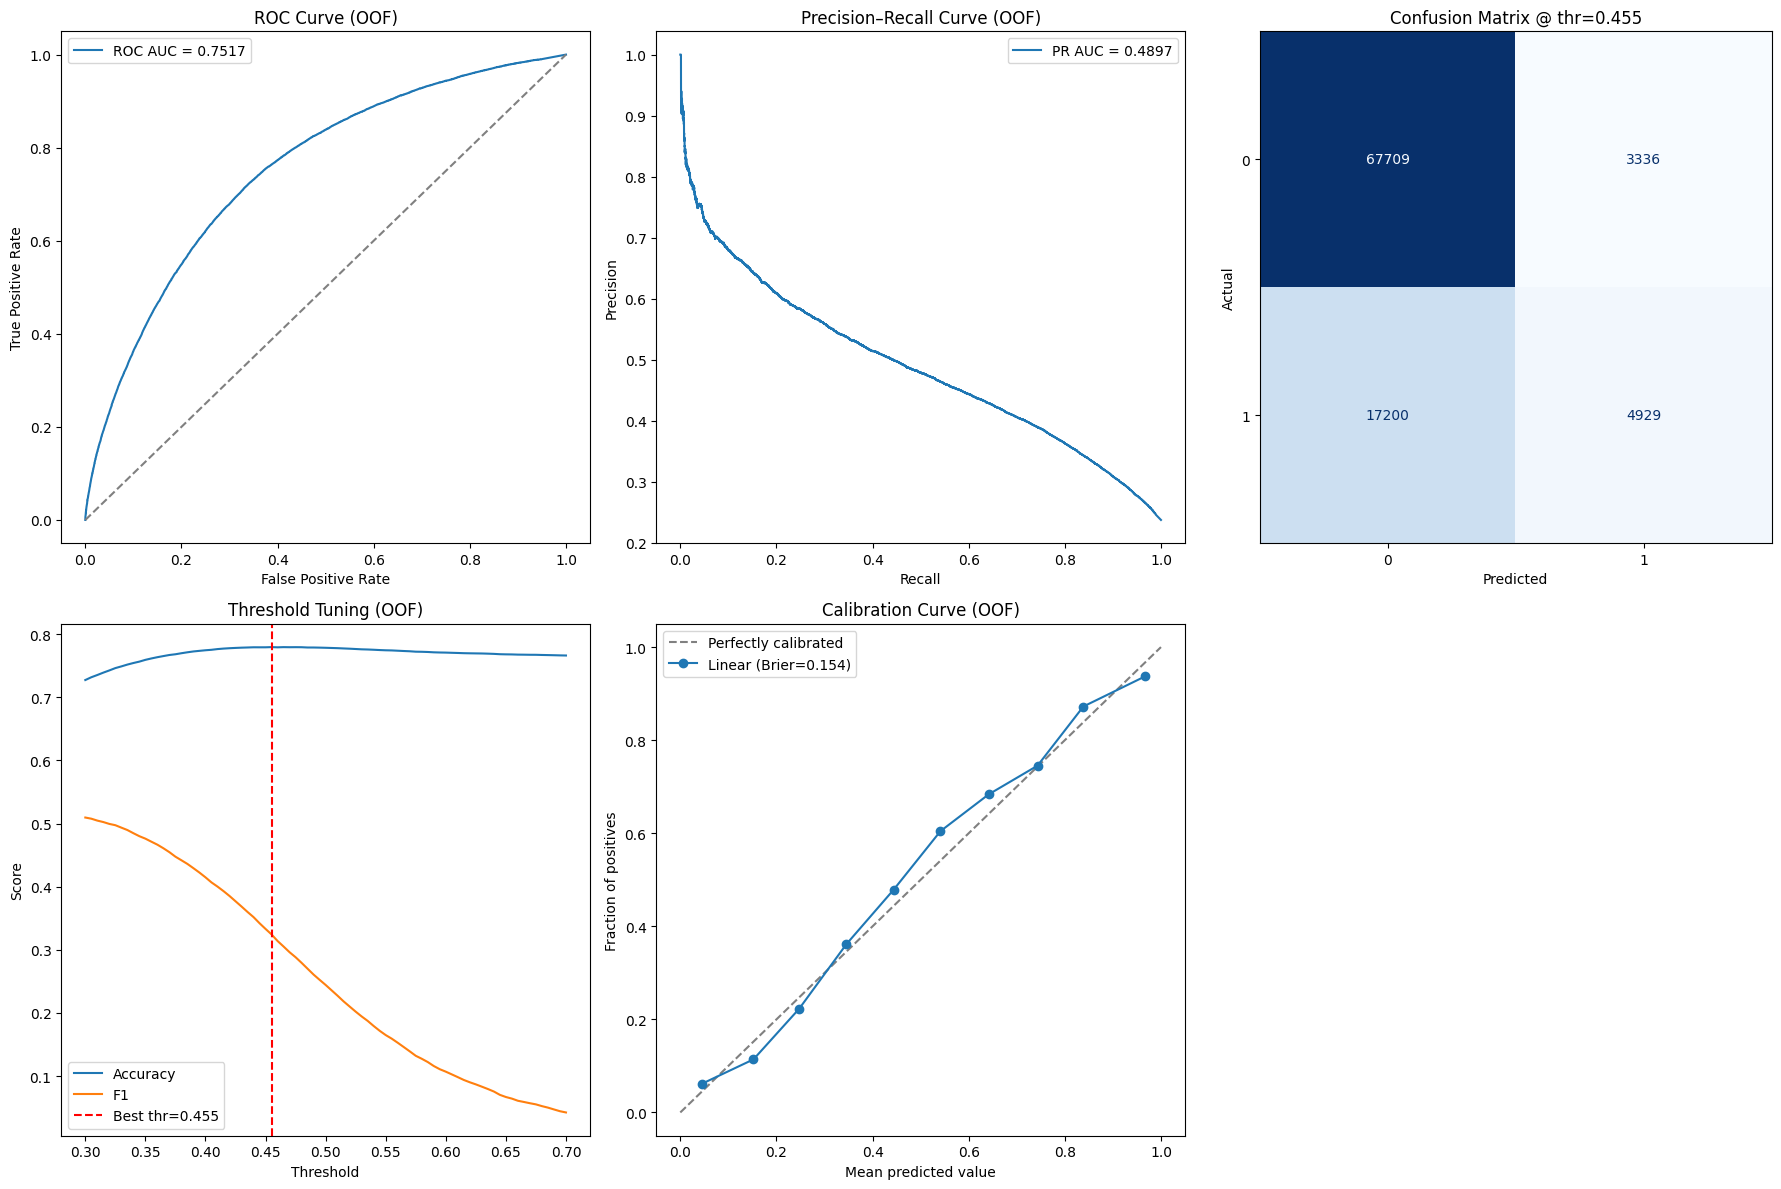

Saved -> submission_linear_regression_adapted.csv


In [66]:
# Prereqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss, classification_report, auc
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

# Assumes: X, y, X_test, train, test, preprocess, SEED, skf already defined

# 1) Hyperparameter tuning using regularized linear models
# Choose a base and a param space; you can switch among Ridge/Lasso/ElasticNet
base = Ridge(random_state=SEED)
param_dist = {
    "model__alpha": np.logspace(-4, 3, 50),          # 1e-4 to 1e3
    # For ElasticNet you could add:
    # "model__l1_ratio": np.linspace(0.0, 1.0, 21)
}

skf = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

tune_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", base)
])

rs = RandomizedSearchCV(
    estimator=tune_pipe,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="neg_mean_squared_error",   # regression loss for tuning raw scores
    cv=skf,
    random_state=SEED,
    n_jobs=-1,
    refit=True,
    verbose=3
)


rs.fit(X, y)  # y is binary; regression fit to produce a continuous score
log_rs_per_split(rs, top_n=10)
print("Best params:", rs.best_params_)
best_pipe = rs.best_estimator_

# 2) OOF predictions, metrics, thresholding
oof_lin = np.zeros(len(train), dtype=float)
test_lin = np.zeros(len(test), dtype=float)
fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    # clone tuned config per fold
    model_cls = type(best_pipe.named_steps["model"])
    model_params = best_pipe.named_steps["model"].get_params()
    fold_pipe = Pipeline(steps=[
        ("prep", best_pipe.named_steps["prep"]),
        ("model", model_cls(**model_params))
    ])

    fold_pipe.fit(X_tr, y_tr)
    proba = np.clip(fold_pipe.predict(X_va), 0.0, 1.0)
    oof_lin[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc.append(acc)

    test_lin += np.clip(fold_pipe.predict(X_test), 0.0, 1.0) / skf.n_splits

print("Linear (regularized) fold accuracies:", np.round(fold_acc, 4), "Mean:", np.mean(fold_acc))

thr_grid = np.linspace(0.3, 0.7, 81)
best_thr_lin = max(thr_grid, key=lambda t: accuracy_score(y, (oof_lin >= t).astype(int)))
best_acc_lin = accuracy_score(y, (oof_lin >= best_thr_lin).astype(int))
print("Best OOF accuracy (Linear-adapted):", round(best_acc_lin, 6), "at threshold:", round(best_thr_lin, 3))

def metrics_at(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return dict(
        threshold=thr,
        accuracy=accuracy_score(y_true, pred),
        precision=precision_score(y_true, pred, zero_division=0),
        recall=recall_score(y_true, pred, zero_division=0),
        f1=f1_score(y_true, pred, zero_division=0)
    )

m05 = metrics_at(y, oof_lin, 0.5)
mbest = metrics_at(y, oof_lin, best_thr_lin)
print("Metrics @0.5:", m05)
print("Metrics @best:", mbest)
print(classification_report(y, (oof_lin >= best_thr_lin).astype(int)))

cm_05 = confusion_matrix(y, (oof_lin >= 0.5).astype(int))
cm_best = confusion_matrix(y, (oof_lin >= best_thr_lin).astype(int))
print("Confusion @0.5:\n", cm_05)
print("Confusion @best:\n", cm_best)

# 3) Curves and plots
roc_auc = roc_auc_score(y, oof_lin)
fpr, tpr, _ = roc_curve(y, oof_lin)
prec, rec, _ = precision_recall_curve(y, oof_lin)
pr_auc = auc(rec, prec)

brier = brier_score_loss(y, oof_lin)
prob_true, prob_pred = calibration_curve(y, oof_lin, n_bins=10, strategy="uniform")
print(f"ROC AUC: {roc_auc:.6f}, PR AUC: {pr_auc:.6f}, Brier: {brier:.6f}")

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF)")
plt.legend()

plt.subplot(2, 3, 3)
disp = ConfusionMatrixDisplay(cm_best)
disp.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_lin:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(2, 3, 4)
accs = [accuracy_score(y, (oof_lin >= t).astype(int)) for t in thr_grid]
f1s = [f1_score(y, (oof_lin >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs, label="Accuracy")
plt.plot(thr_grid, f1s, label="F1")
plt.axvline(best_thr_lin, color="red", linestyle="--", label=f"Best thr={best_thr_lin:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF)")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, marker="o", label=f"Linear (Brier={brier:.3f})")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (OOF)")
plt.legend()

plt.tight_layout()
plt.show()

# 5) Export submission using best threshold
submission_lin = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_lin >= best_thr_lin).astype(int)
})
submission_lin.to_csv("submission_linear_regression_adapted.csv", index=False)
print("Saved -> submission_linear_regression_adapted.csv")

ISO fold accuracies: [0.7102 0.7105 0.6989] Mean: 0.7065061068538433
Best OOF accuracy (ISO): 0.762455 at threshold: 0.95
ISO Metrics @0.5: {'threshold': 0.5, 'accuracy': 0.7065061068538433, 'precision': 0.13985917437525888, 'recall': 0.04577703466040038, 'f1': 0.06897725725180444}
ISO Metrics @best: {'threshold': np.float64(0.95), 'accuracy': 0.7624551913623973, 'precision': 0.16666666666666666, 'recall': 4.518957024718695e-05, 'f1': 9.03546419697312e-05}
              precision    recall  f1-score   support

           0       0.76      1.00      0.87     71045
           1       0.17      0.00      0.00     22129

    accuracy                           0.76     93174
   macro avg       0.46      0.50      0.43     93174
weighted avg       0.62      0.76      0.66     93174

ISO Confusion @0.5:
 [[64815  6230]
 [21116  1013]]
ISO Confusion @best:
 [[71040     5]
 [22128     1]]


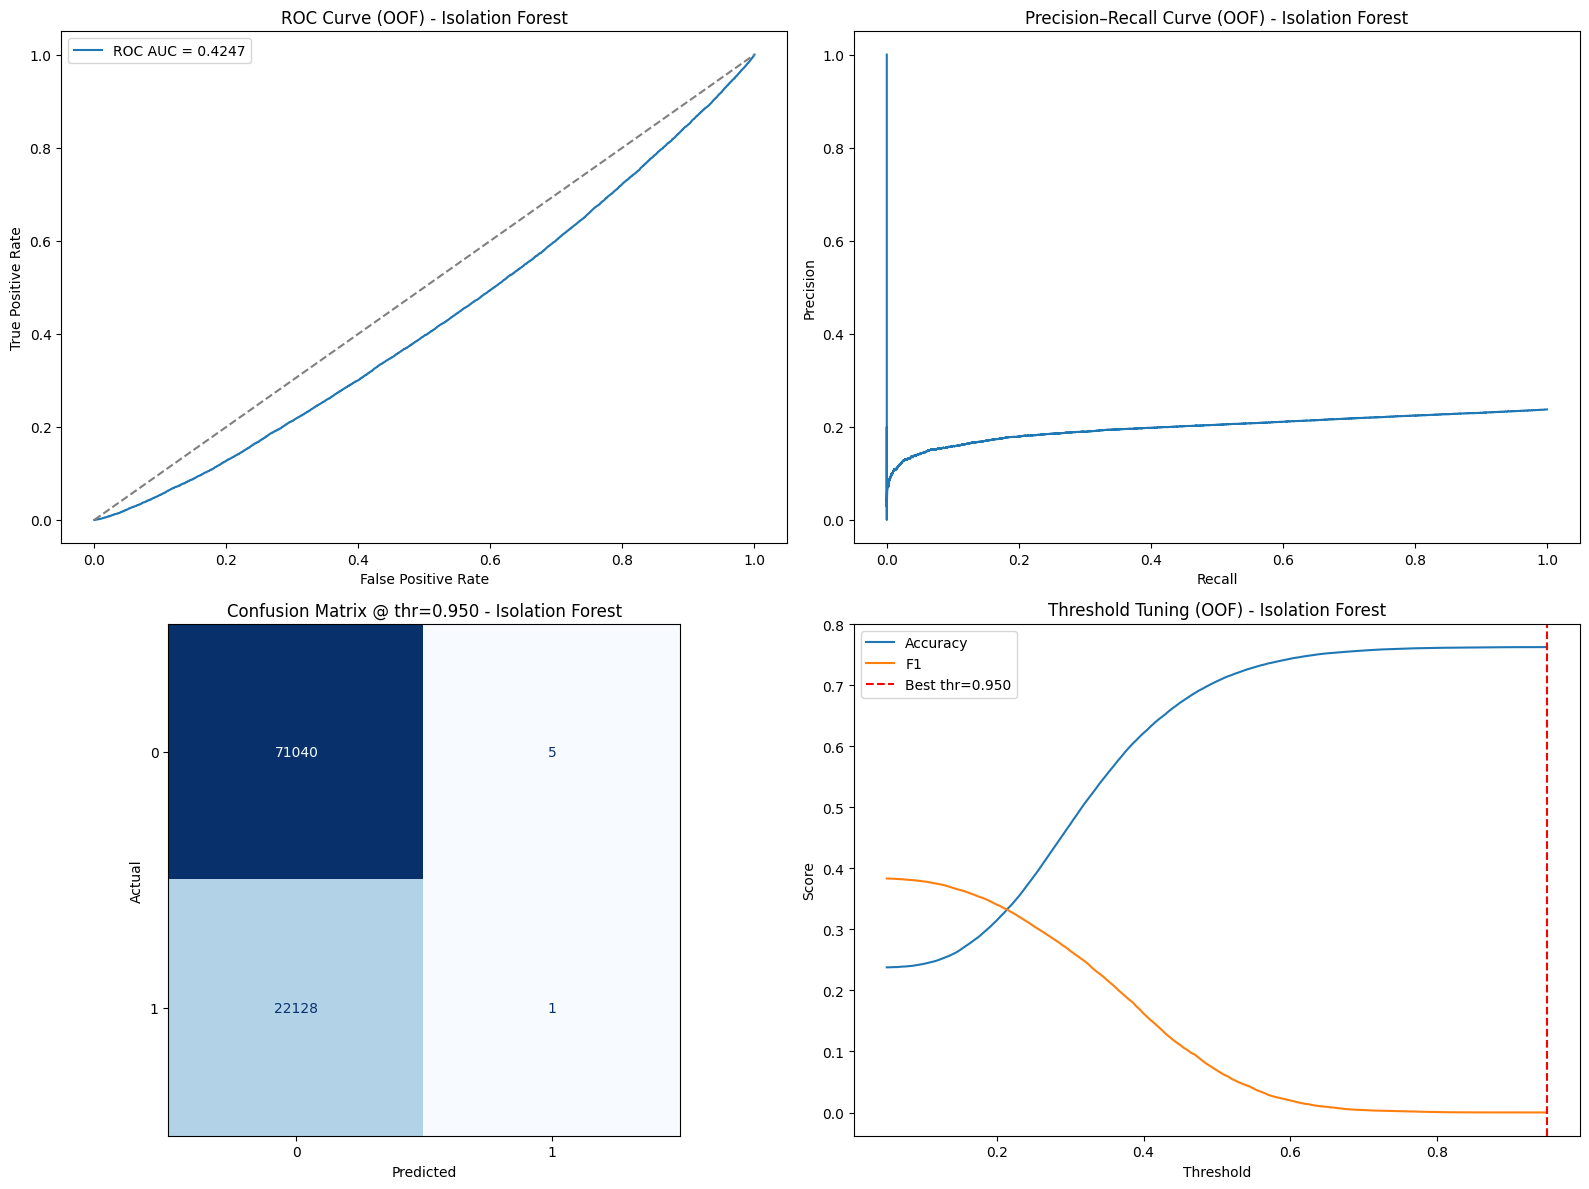

Saved -> submission_isolation_forest.csv


In [67]:
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, ClassifierMixin, clone

# Wrapper to make IsolationForest behave like a probabilistic classifier for binary y
class IsoForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_if=None, contamination="auto"):
        self.base_if = base_if if base_if is not None else IsolationForest(
            n_estimators=300, max_samples="auto", contamination=contamination,
            random_state=SEED, n_jobs=-1
        )
        self.contamination = contamination
        self.fitted_ = False

    def fit(self, X, y=None):
        self.if_ = clone(self.base_if)
        self.if_.fit(X)
        # scores: higher = more normal. Convert to anomaly score in [0,1]
        self.decision_scores_ = self.if_.decision_function(X)  # approx [-0.5, 0.5], larger is normal
        # Normalize to [0,1] and invert so that higher means more likely positive (default)
        s = self.decision_scores_
        s_min, s_max = np.min(s), np.max(s)
        if s_max > s_min:
            norm = (s - s_min) / (s_max - s_min)
        else:
            norm = np.zeros_like(s)
        self.proba_ = 1.0 - norm  # higher => more anomalous
        self.fitted_ = True
        return self

    def predict_proba(self, X):
        s = self.if_.decision_function(X)
        # same scaling on-the-fly (use train mins/maxes if strict; for simplicity use per-batch)
        s_min, s_max = np.min(s), np.max(s)
        if s_max > s_min:
            norm = (s - s_min) / (s_max - s_min)
        else:
            norm = np.zeros_like(s)
        p_anom = 1.0 - norm
        p_anom = np.clip(p_anom, 0.0, 1.0)
        # binary proba: [:,0]=neg, [:,1]=pos
        return np.vstack([1.0 - p_anom, p_anom]).T

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= threshold).astype(int)

# ---- Pipeline with preprocessing ----
iso_clf = IsoForestClassifier(
    base_if=IsolationForest(
        n_estimators=500,
        max_samples="auto",
        contamination="auto",  # or set to y.mean() if you prefer to match positive rate
        random_state=SEED,
        n_jobs=-1,
        verbose=0
    )
)

iso_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", iso_clf)
])

# ---- OOF using StratifiedKFold against labels ----
oof_iso = np.zeros(len(train), dtype=float)
test_iso = np.zeros(len(test), dtype=float)
fold_acc_iso = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    iso_fold = Pipeline(steps=[
        ("prep", iso_pipe.named_steps["prep"]),
        ("model", IsoForestClassifier(
            base_if=IsolationForest(
                n_estimators=500,
                max_samples="auto",
                contamination="auto",
                random_state=SEED
            )
        ))
    ])

    iso_fold.fit(X_tr, None)  # unsupervised fit
    proba = iso_fold.predict_proba(X_va)[:, 1]
    oof_iso[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc_iso.append(acc)

    test_iso += iso_fold.predict_proba(X_test)[:, 1] / skf.n_splits

print("ISO fold accuracies:", np.round(fold_acc_iso, 4), "Mean:", np.mean(fold_acc_iso))

# ---- Threshold tuning vs labels ----
thr_grid = np.linspace(0.05, 0.95, 181)
best_thr_iso = max(thr_grid, key=lambda t: accuracy_score(y, (oof_iso >= t).astype(int)))
best_acc_iso = accuracy_score(y, (oof_iso >= best_thr_iso).astype(int))
print("Best OOF accuracy (ISO):", round(best_acc_iso, 6), "at threshold:", round(best_thr_iso, 3))

# ---- Metrics / plots ----
m05_iso = metrics_at(y, oof_iso, 0.5)
mbest_iso = metrics_at(y, oof_iso, best_thr_iso)
print("ISO Metrics @0.5:", m05_iso)
print("ISO Metrics @best:", mbest_iso)
print(classification_report(y, (oof_iso >= best_thr_iso).astype(int)))

cm05_iso = confusion_matrix(y, (oof_iso >= 0.5).astype(int))
cmbest_iso = confusion_matrix(y, (oof_iso >= best_thr_iso).astype(int))
print("ISO Confusion @0.5:\n", cm05_iso)
print("ISO Confusion @best:\n", cmbest_iso)

roc_auc_iso = roc_auc_score(y, oof_iso)
fpr_iso, tpr_iso, _ = roc_curve(y, oof_iso)
prec_iso, rec_iso, _ = precision_recall_curve(y, oof_iso)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(fpr_iso, tpr_iso, label=f"ROC AUC = {roc_auc_iso:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF) - Isolation Forest")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rec_iso, prec_iso)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF) - Isolation Forest")

plt.subplot(2, 2, 3)
disp_iso = ConfusionMatrixDisplay(cmbest_iso)
disp_iso.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_iso:.3f} - Isolation Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(2, 2, 4)
accs_iso = [accuracy_score(y, (oof_iso >= t).astype(int)) for t in thr_grid]
f1s_iso = [f1_score(y, (oof_iso >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs_iso, label="Accuracy")
plt.plot(thr_grid, f1s_iso, label="F1")
plt.axvline(best_thr_iso, color="red", linestyle="--", label=f"Best thr={best_thr_iso:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF) - Isolation Forest")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Export submission ----
submission_iso = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_iso >= best_thr_iso).astype(int)
})
submission_iso.to_csv("submission_isolation_forest.csv", index=False)
print("Saved -> submission_isolation_forest.csv")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   23.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  2.3min finished



Rank: 1  Mean: 0.82246 ± 0.00148
Params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 24, 'model__class_weight': 'balanced_subsample', 'model__bootstrap': True}
  split0_test_score: 0.82407
  split1_test_score: 0.82282
  split2_test_score: 0.82050

Rank: 2  Mean: 0.81836 ± 0.00201
Params: {'model__n_estimators': 1200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 24, 'model__class_weight': 'balanced_subsample', 'model__bootstrap': True}
  split0_test_score: 0.82001
  split1_test_score: 0.81953
  split2_test_score: 0.81554

Rank: 3  Mean: 0.80315 ± 0.00187
Params: {'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 24, 'model__class_weight': 'balanced_subsample', 'model__bootstrap': True}
  split0_test_score: 0.80317
  split1_test_score: 0

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   55.6s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   55.9s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done  49 tasks    

RF fold accuracies: [0.8237 0.8234 0.8202] Mean: 0.8224290037993431
Best OOF accuracy (RF): 0.824168 at threshold: 0.535
Metrics @0.5: {'threshold': 0.5, 'accuracy': 0.8224290037993431, 'precision': 0.7500447787927638, 'recall': 0.3784626508201907, 'f1': 0.5030785403213696}
Metrics @best: {'threshold': np.float64(0.5349999999999999), 'accuracy': 0.8241676862644085, 'precision': 0.8065514297908664, 'recall': 0.34158796149848614, 'f1': 0.4799212723405606}
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     71045
           1       0.81      0.34      0.48     22129

    accuracy                           0.82     93174
   macro avg       0.82      0.66      0.69     93174
weighted avg       0.82      0.82      0.80     93174

Confusion @0.5:
 [[68254  2791]
 [13754  8375]]
Confusion @best:
 [[69232  1813]
 [14570  7559]]


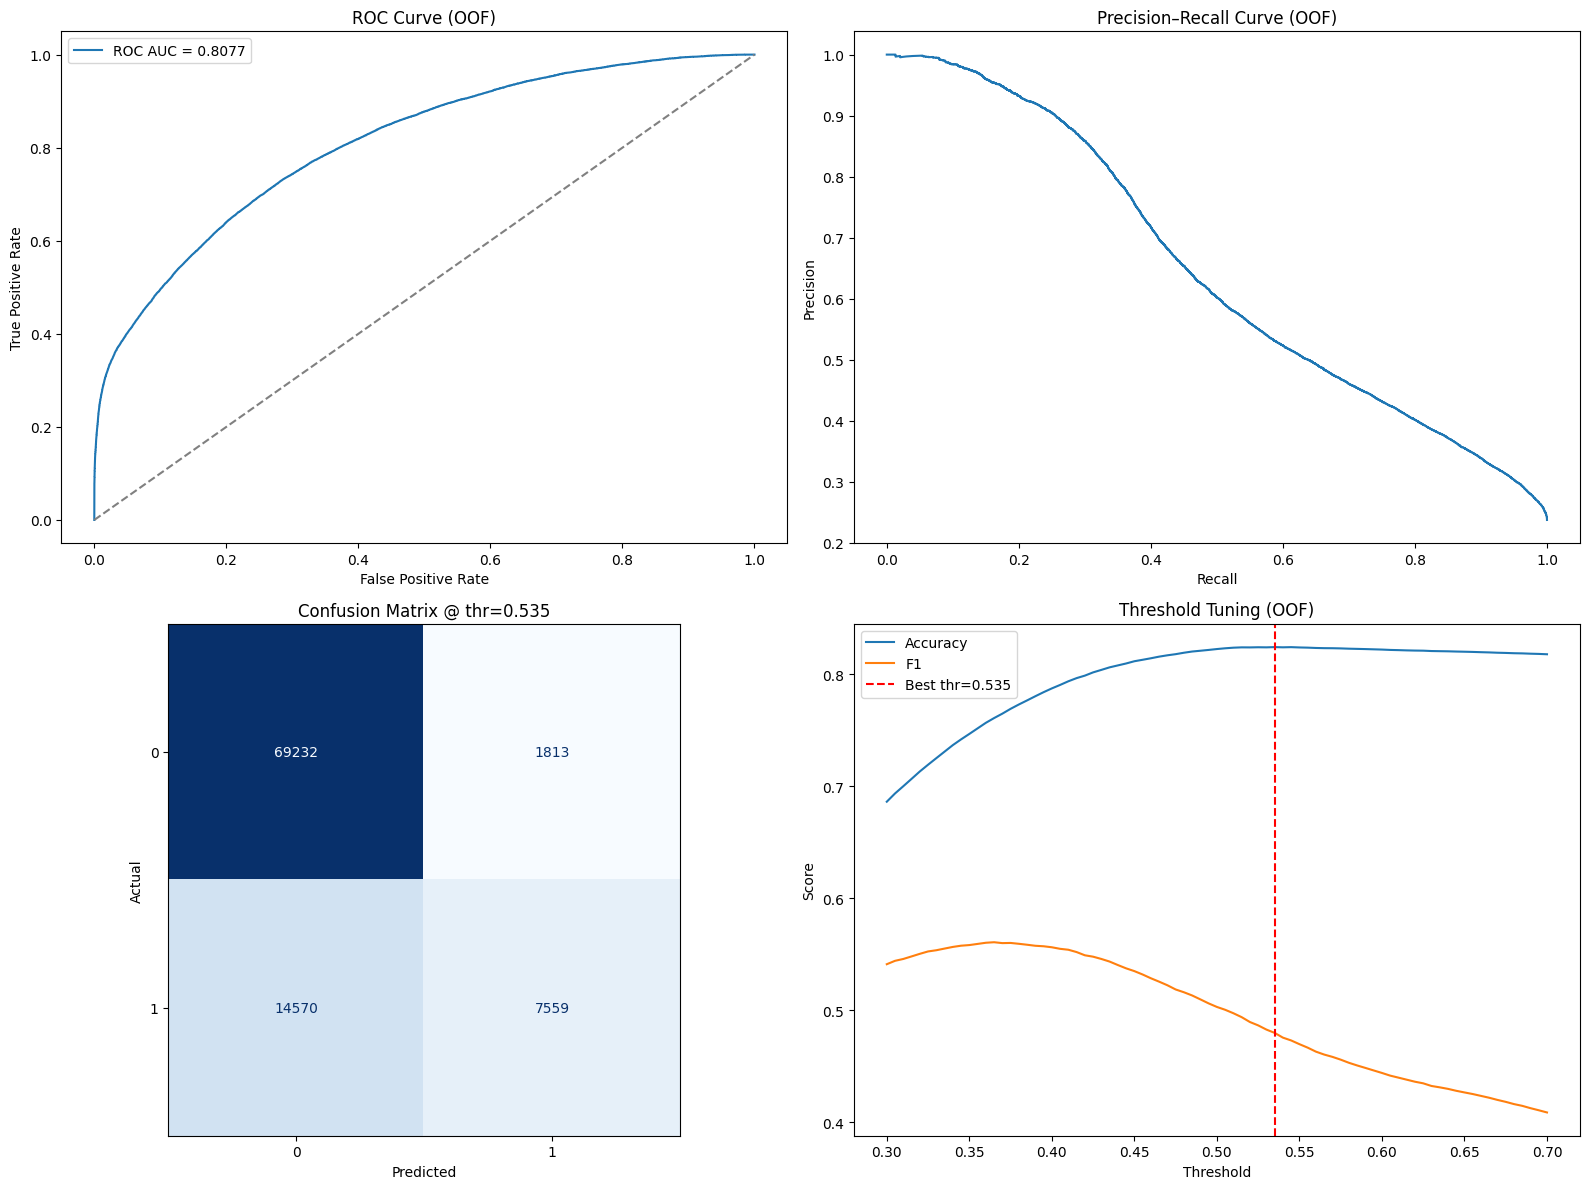

Saved -> submission_random_forest.csv


In [68]:
# Prereqs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.inspection import permutation_importance

# ---- Your base params ----
rf_params = dict(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=SEED,
    class_weight="balanced_subsample",
    verbose=True
)

rf_clf = RandomForestClassifier(**rf_params)

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf_clf)
])

skf = StratifiedKFold(n_splits=K_FOLD_COUNT, shuffle=True, random_state=SEED)

# ---- RandomizedSearchCV over key knobs ----
param_dist = {
    "model__n_estimators": [300, 500, 800, 1200],
    "model__max_depth": [None, 6, 10, 16, 24],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.8],
    "model__bootstrap": [True],  # keep bootstrap consistent
    "model__class_weight": ["balanced_subsample"],  # maintain imbalance handling
}

rand_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",
    n_jobs=-1,
    cv=skf,
    random_state=SEED,
    verbose=3,
    refit=True
)

rand_search.fit(X, y)
log_rs_per_split(rand_search, top_n=10)
print("Best params:", rand_search.best_params_)
print("Best CV accuracy:", rand_search.best_score_)

best_pipe = rand_search.best_estimator_

# ---- Cross-validated OOF predictions ----
oof_rf = np.zeros(len(train), dtype=float)
test_rf = np.zeros(len(test), dtype=float)
fold_acc = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    # clone tuned config per fold
    rf_fold = Pipeline(steps=[
        ("prep", best_pipe.named_steps["prep"]),
        ("model", RandomForestClassifier(**best_pipe.named_steps["model"].get_params()))
    ])

    rf_fold.fit(X_tr, y_tr)

    proba = rf_fold.predict_proba(X_va)[:, 1]
    oof_rf[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc.append(acc)

    test_rf += rf_fold.predict_proba(X_test)[:, 1] / skf.n_splits

print("RF fold accuracies:", np.round(fold_acc, 4), "Mean:", np.mean(fold_acc))

# ---- Threshold tuning on OOF ----
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr_rf = max(thr_grid, key=lambda t: accuracy_score(y, (oof_rf >= t).astype(int)))
best_acc_rf = accuracy_score(y, (oof_rf >= best_thr_rf).astype(int))
print("Best OOF accuracy (RF):", round(best_acc_rf, 6), "at threshold:", round(best_thr_rf, 3))

# ---- Metrics at 0.5 and best threshold ----
def metrics_at(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return dict(
        threshold=thr,
        accuracy=accuracy_score(y_true, pred),
        precision=precision_score(y_true, pred, zero_division=0),
        recall=recall_score(y_true, pred, zero_division=0),
        f1=f1_score(y_true, pred, zero_division=0)
    )

m05 = metrics_at(y, oof_rf, 0.5)
mbest = metrics_at(y, oof_rf, best_thr_rf)
print("Metrics @0.5:", m05)
print("Metrics @best:", mbest)
print(classification_report(y, (oof_rf >= best_thr_rf).astype(int)))

# ---- Confusion matrices ----
cm_05 = confusion_matrix(y, (oof_rf >= 0.5).astype(int))
cm_best = confusion_matrix(y, (oof_rf >= best_thr_rf).astype(int))
print("Confusion @0.5:\n", cm_05)
print("Confusion @best:\n", cm_best)

# ---- ROC/PR curves ----
roc_auc = roc_auc_score(y, oof_rf)
fpr, tpr, _ = roc_curve(y, oof_rf)
prec, rec, _ = precision_recall_curve(y, oof_rf)

plt.figure(figsize=(16, 12))

# ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()

# PR curve
plt.subplot(2, 2, 2)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF)")

# Confusion matrix (best threshold)
plt.subplot(2, 2, 3)
disp = ConfusionMatrixDisplay(cm_best)
disp.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_rf:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Threshold vs accuracy/F1
plt.subplot(2, 2, 4)
accs = [accuracy_score(y, (oof_rf >= t).astype(int)) for t in thr_grid]
f1s = [f1_score(y, (oof_rf >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs, label="Accuracy")
plt.plot(thr_grid, f1s, label="F1")
plt.axvline(best_thr_rf, color="red", linestyle="--", label=f"Best thr={best_thr_rf:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF)")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Export submission using best threshold ----
submission_rf = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_rf >= best_thr_rf).astype(int)
})
submission_rf.to_csv("submission_random_forest.csv", index=False)
print("Saved -> submission_random_forest.csv")

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Rank: 1  Mean: 0.76708 ± 0.00376
Params: {'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 0.8, 'model__max_depth': None, 'model__class_weight': 'balanced'}
  split0_test_score: 0.76357
  split1_test_score: 0.77230
  split2_test_score: 0.76537

Rank: 2  Mean: 0.74915 ± 0.01375
Params: {'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 0.8, 'model__max_depth': None, 'model__class_weight': 'balanced'}
  split0_test_score: 0.75977
  split1_test_score: 0.72973
  split2_test_score: 0.75794

Rank: 3  Mean: 0.74449 ± 0.00731
Params: {'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 0.8, 'model__max_depth': 32, 'model__class_weight': 'balanced'}
  split0_test_score: 0.75204
  split1_test_score: 0.73459
  split2_test_score: 0.74683

Rank: 4  Mean: 0.70842 ± 0.03096
Params: {'model__min_samples_split': 2, 'model__min_samples_leaf': 

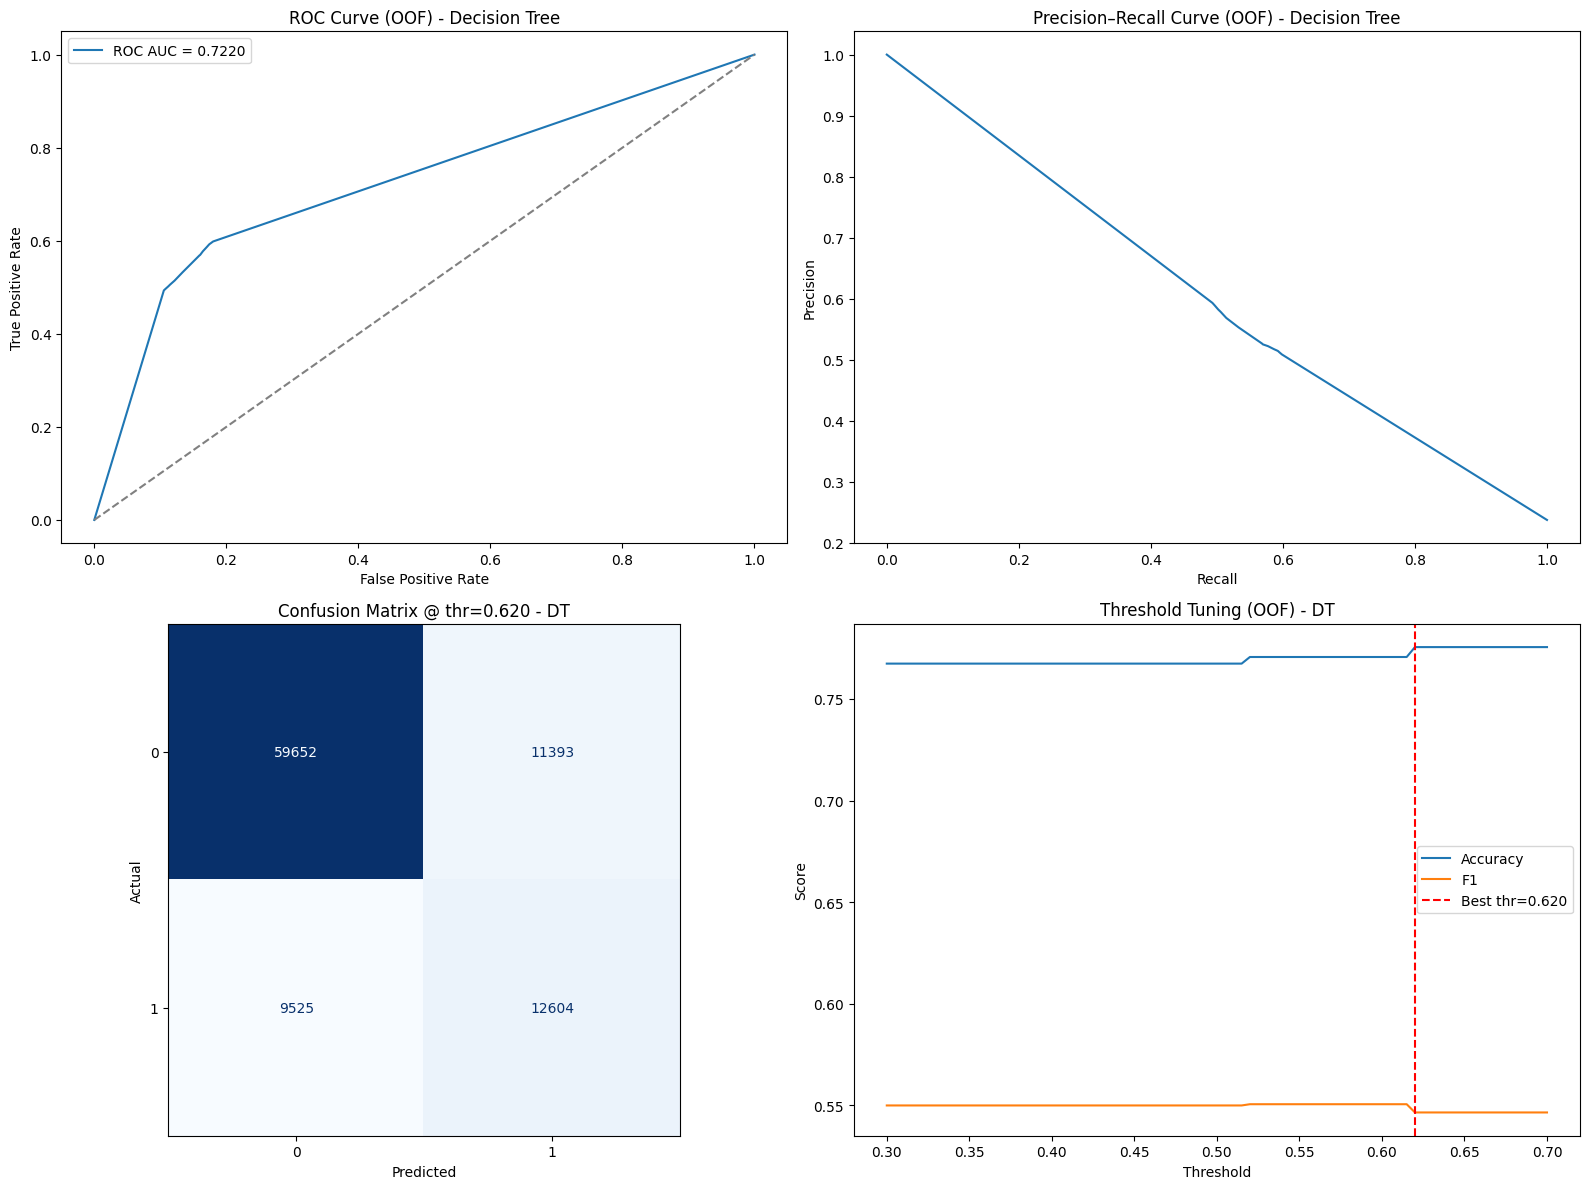

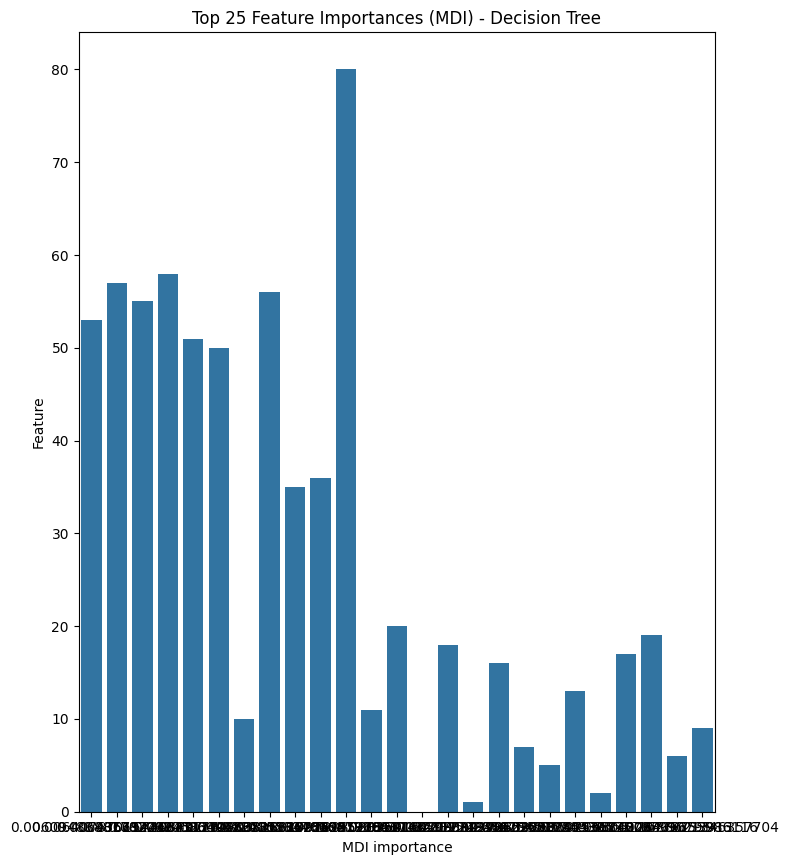

Saved -> submission_decision_tree.csv


In [69]:
from sklearn.tree import DecisionTreeClassifier

# ---- Base params ----
dt_params = dict(
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,  # DT often uses all features; can tune
    random_state=SEED,
    class_weight="balanced"  # handle imbalance
)

dt_clf = DecisionTreeClassifier(**dt_params)

dt_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", dt_clf)
])

# ---- RandomizedSearchCV space ----
param_dist_dt = {
    "model__max_depth": [None, 4, 6, 10, 16, 24, 32],
    "model__min_samples_split": [2, 5, 10, 20, 50],
    "model__min_samples_leaf": [1, 2, 4, 8, 16],
    "model__max_features": [None, "sqrt", "log2", 0.5, 0.8],
    "model__class_weight": ["balanced"]  # keep consistent
}

rand_search_dt = RandomizedSearchCV(
    estimator=dt_pipe,
    param_distributions=param_dist_dt,
    n_iter=N_ITER_COUNT,
    scoring="accuracy",
    n_jobs=-1,
    cv=skf,
    random_state=SEED,
    verbose=3,
    refit=True
)

rand_search_dt.fit(X, y)
log_rs_per_split(rand_search_dt, top_n=10)
print("DT best params:", rand_search_dt.best_params_)
print("DT best CV acc:", rand_search_dt.best_score_)

best_dt_pipe = rand_search_dt.best_estimator_

# ---- OOF predictions ----
oof_dt = np.zeros(len(train), dtype=float)
test_dt = np.zeros(len(test), dtype=float)
fold_acc_dt = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
    X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

    dt_fold = Pipeline(steps=[
        ("prep", best_dt_pipe.named_steps["prep"]),
        ("model", DecisionTreeClassifier(**best_dt_pipe.named_steps["model"].get_params()))
    ])

    dt_fold.fit(X_tr, y_tr)

    # predict_proba exists; for binary it gives [:,1]
    proba = dt_fold.predict_proba(X_va)[:, 1]
    oof_dt[va_idx] = proba
    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_va, pred)
    fold_acc_dt.append(acc)

    test_dt += dt_fold.predict_proba(X_test)[:, 1] / skf.n_splits

print("DT fold accuracies:", np.round(fold_acc_dt, 4), "Mean:", np.mean(fold_acc_dt))

# ---- Threshold tuning ----
thr_grid = np.linspace(0.3, 0.7, 81)
best_thr_dt = max(thr_grid, key=lambda t: accuracy_score(y, (oof_dt >= t).astype(int)))
best_acc_dt = accuracy_score(y, (oof_dt >= best_thr_dt).astype(int))
print("Best OOF accuracy (DT):", round(best_acc_dt, 6), "at threshold:", round(best_thr_dt, 3))

# ---- Metrics ----
m05_dt = metrics_at(y, oof_dt, 0.5)
mbest_dt = metrics_at(y, oof_dt, best_thr_dt)
print("DT Metrics @0.5:", m05_dt)
print("DT Metrics @best:", mbest_dt)
print(classification_report(y, (oof_dt >= best_thr_dt).astype(int)))

# ---- Confusion matrices ----
cm05_dt = confusion_matrix(y, (oof_dt >= 0.5).astype(int))
cmbest_dt = confusion_matrix(y, (oof_dt >= best_thr_dt).astype(int))
print("DT Confusion @0.5:\n", cm05_dt)
print("DT Confusion @best:\n", cmbest_dt)

# ---- ROC/PR ----
roc_auc_dt = roc_auc_score(y, oof_dt)
fpr_dt, tpr_dt, _ = roc_curve(y, oof_dt)
prec_dt, rec_dt, _ = precision_recall_curve(y, oof_dt)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.plot(fpr_dt, tpr_dt, label=f"ROC AUC = {roc_auc_dt:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF) - Decision Tree")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(rec_dt, prec_dt)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (OOF) - Decision Tree")

plt.subplot(2, 2, 3)
disp_dt = ConfusionMatrixDisplay(cmbest_dt)
disp_dt.plot(values_format="d", cmap="Blues", ax=plt.gca(), colorbar=False)
plt.title(f"Confusion Matrix @ thr={best_thr_dt:.3f} - DT")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(2, 2, 4)
accs_dt = [accuracy_score(y, (oof_dt >= t).astype(int)) for t in thr_grid]
f1s_dt = [f1_score(y, (oof_dt >= t).astype(int)) for t in thr_grid]
plt.plot(thr_grid, accs_dt, label="Accuracy")
plt.plot(thr_grid, f1s_dt, label="F1")
plt.axvline(best_thr_dt, color="red", linestyle="--", label=f"Best thr={best_thr_dt:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning (OOF) - DT")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Feature importances ----
best_dt_full = Pipeline(steps=[
    ("prep", best_dt_pipe.named_steps["prep"]),
    ("model", DecisionTreeClassifier(**best_dt_pipe.named_steps["model"].get_params()))
])
best_dt_full.fit(X, y)

try:
    feat_names = best_dt_full.named_steps["prep"].get_feature_names_out()
except Exception:
    feat_names = np.arange(best_dt_full.named_steps["model"].n_features_in_)

mdi_dt = best_dt_full.named_steps["model"].feature_importances_
fi_mdi_dt = pd.DataFrame({"feature": feat_names, "importance": mdi_dt}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, max(4, min(20, len(fi_mdi_dt.head(25)) * 0.35))))
sns.barplot(data=fi_mdi_dt.head(25), x="importance", y="feature")
plt.title("Top 25 Feature Importances (MDI) - Decision Tree")
plt.xlabel("MDI importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ---- Export submission ----
submission_dt = pd.DataFrame({
    "ID": test["ID"].values,
    "default": (test_dt >= best_thr_dt).astype(int)
})
submission_dt.to_csv("submission_decision_tree.csv", index=False)
print("Saved -> submission_decision_tree.csv")

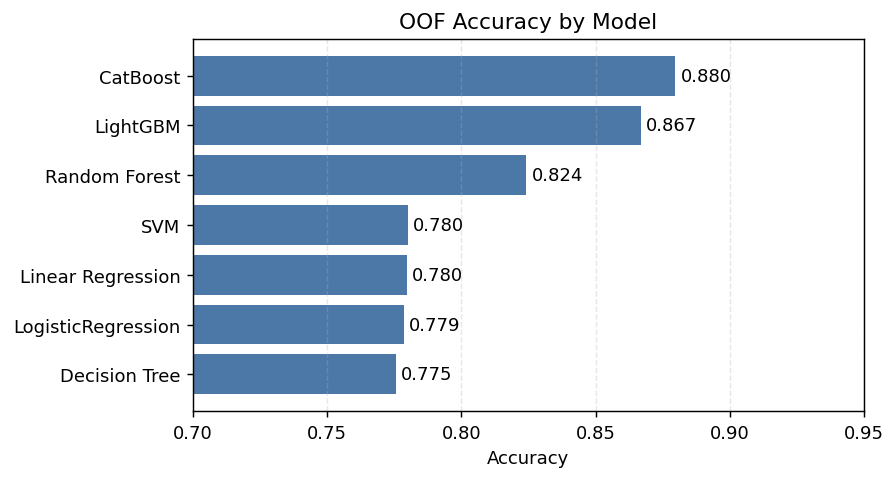

In [70]:
# Accuracy comparison chart in-notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Record OOF accuracies from your runs (replace with real values)
acc_lgbm = best_oof_acc   # print from LightGBM block
acc_cat  = best_acc_cb   # print from CatBoost block
acc_rf   = best_acc_rf   # print from Random Forest block
acc_svm  = best_acc_svm   # print from SVM block
acc_lin  = best_acc_lin   # print from Linear Regression block
acc_lr   = best_acc_lr
acc_dt   = best_acc_dt

df_acc = pd.DataFrame({
    "Model": ["CatBoost", "LightGBM", "Random Forest", "SVM", "Linear Regression", "LogisticRegression", "Decision Tree"],
    "Accuracy": [acc_cat, acc_lgbm, acc_rf, acc_svm, acc_lin, acc_lr, acc_dt]
}).sort_values("Accuracy", ascending=True)

# 2) Plot
plt.figure(figsize=(7, 3.8), dpi=130)
bars = plt.barh(df_acc["Model"], df_acc["Accuracy"], color="#4C78A8")
plt.xlim(0.70, 0.95)
plt.xlabel("Accuracy")
plt.title("OOF Accuracy by Model")

# 3) Label bars
for b, v in zip(bars, df_acc["Accuracy"]):
    plt.text(v + 0.002, b.get_y() + b.get_height()/2, f"{v:.3f}", va="center")

plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
